# Prepare

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy

import experiments as meas
from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']


In [2]:
# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

Server status: healthy
Pending jobs: 0


In [3]:
# Who is running these experiments??
user = 'connie'

print(f"Welcome {user}!")

Welcome connie!


In [4]:
# station.update_all_station_snapshots(update_main=True)

In [12]:
# Initialize station to retrieve soc and configs
station = MultimodeStation(
    user = user,
    experiment_name = "260112_qsim_calibration_practice",
    # storage_man_file = "CFG-M1-20260122-00013",
    # hardware_config="versions/hardware_config/CFG-HW-20260121-00006.yml",
    # floquet_file="versions/floquet_storage_swap/CFG-FL-20260115-00001.csv",
    # storage_man_file="versions/man1_storage_swap/CFG-M1-20260121-00005.csv",
    # multiphoton_config="versions/multiphoton_config/CFG-MP-20260115-00001.yml",
    
    # experiment_name = "251111_qec",
)

[STATION] Using main hardware_config version: CFG-HW-20260122-00015
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260122-00013
[STATION] Using main floquet_storage_swap version: CFG-FL-20260121-00001
Data, plots, logs will be stored in: D:\experiments\260112_qsim_calibration_practice
Hardware configs will be read from D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260122-00015.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399

## Notes

### File path management

- Let's transition to `Pathlib` instead of `os.path` everywhere. This is the modern way.
- You no longer have to specify the location of this python repo itself. Python can figure out where it's running and store this in `station.repo_root`.
- Config files, `yaml` or `csv`, are always under `station.config_dir`.
- Data, plots and logs DO NOT belong in the git repo! These are considered outputs of the code. Find a fixed place on the hard drive dedicated to storing these files and set the `data_management` field in the hardware config yaml to that. This is `station.output_root`.
- Each experiment is given an experiment name eg `[date]_(qsim|qec)`. This is a corresponding directory under `output_root` and it's called `station.experiment_path`. It will be automatically created for you if not present, so check for typos carefully!
- Under `station.experiment_path`, we also automatically create `station.data_path` for hdf5 files, `station.plot_path` for images and `station.log_path` for logs. Under plots, we also have a `station.autocalib_path` auto created using the date.


### Handling of parameter updating: 

The experiment objects are initialized with the `station.config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `station.hardware_cfg` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.

A better architecture in the future might be to ditch relying on objects in memory and write results to disk after every measurement.
Since we use git and also make yet another copy of the yaml or csv as "backup", recovering from a bad file-write should not be a problem. 
Eg we can just aggressively write to the canonical file, keeping the new "backup" one file-write behind, and add an undo function that pulls the corresponding field from the backup or git history into the canonical file again.
This allows measurements and analysis done in one notebook to be immediately available to other notebooks. 

#### One other alternative: (Connie)
Google uses a "snapshot ID" way of storing config parameters (e.g. [here](https://github.com/quantumlib/Cirq/blob/v1.6.1/cirq-google/cirq_google/engine/abstract_processor.py#L57-L122)). This means that there is a full config stored at each time that the snapshot is created, and any snapshot can later be retrieved or reverted to.

## Experiments to run

Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

In [13]:
expts_to_run = {# readout 
                'res_spec': True, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': True,
                't2_ge': True, 
                'amplitude_ge': True,
                't1_ge': True,
                # qubit ef
                'pulse_probe_ef': True,
                't2_ef': True,
                'amplitude_ef': True,
                't1_ef': True,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': True,
                'length_rabi_sweep':True,
                'length_rabi':False, # this will run automatically if the length_rabi_sweep is set to True
                'chi_ge': True, 
                'chi_ef': True,
                'RB': False,

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                # 'stor_modes': [3, 4, 5], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': True,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

# Qubit characterization

## Update main configs

In [ ]:
# When ready uncomment:
# station.update_all_station_snapshots(update_main=True)

## Resonator spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [8]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
resspec_defaults = AttrDict(dict(
    # start = center - span / 2, 
    # step = span / expts, # min step ~1 Hz
    # center and span can be user supplied or use defaults in preproc
    expts = 250, # Number experiments stepping from start
    reps = 500, # Number averages per point
    relax_delay = 50, # us
    pulse_e = False, # add ge pi pulse prior to measurement
    pulse_f = False, # add ef pi pulse prior to measurement
    pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
    cavity_pulse = [4984.373226159381, 800, 2, 0], # [frequency, gain, length, phase]  const pulse
    qubit = 0,
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def resspec_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)

    span = kwargs.pop('span', 1.5)  # MHz
    center = kwargs.pop('center', station.hardware_cfg.device.readout.frequency[0])
    expts = kwargs.get('expts', default_expt_cfg.expts)

    expt_cfg.start = center - span / 2
    expt_cfg.step = span / expts
    expt_cfg.update(kwargs)
    return expt_cfg

def resspec_postproc(station, expt):
    old_freq = station.hardware_cfg.device.readout.frequency[0]
    station.hardware_cfg.device.readout.frequency = [expt.data['fit'][0]]
    print(f'Updated readout frequency from {old_freq} to {expt.data["fit"][0]}!')


Job submitted: JOB-20260122-00023 (queue position: 1)

[0.1s] Job JOB-20260122-00023: pending

[2.1s] Job JOB-20260122-00023: running
[WORKER] Loading ResonatorSpectroscopyExperiment from experiments.single_qubit.resonator_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00023_ResonatorSpectroscopyExperiment.h5
[WORKER] Running experiment...
 96%|██████████████████████████████████████▍ | 240/250 [00:18<00:00, 13.20it/s]
[26.3s] Job JOB-20260122-00023: completed
100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.23it/s]
[749.4481507749348, 5000, 1000, 0, 108.71917030446508, 90.82478085073197, 22.764927732465388]
[ 7.49448728e+02  3.31957217e+10  1.10133120e+03 -8.50603133e-01
  1.10908706e+02 -8.22428137e-01 -2.65269471e+01]

Freq with minimum transmission: 749.2111507749349
Freq with maximum transmission: 749.781150774935
From fit:
	f0: 749.448728162673
	Qi: 33195721745.969772
	Qe: 1101.3312012881293
	Q0: 1101.3311647493733
	kap

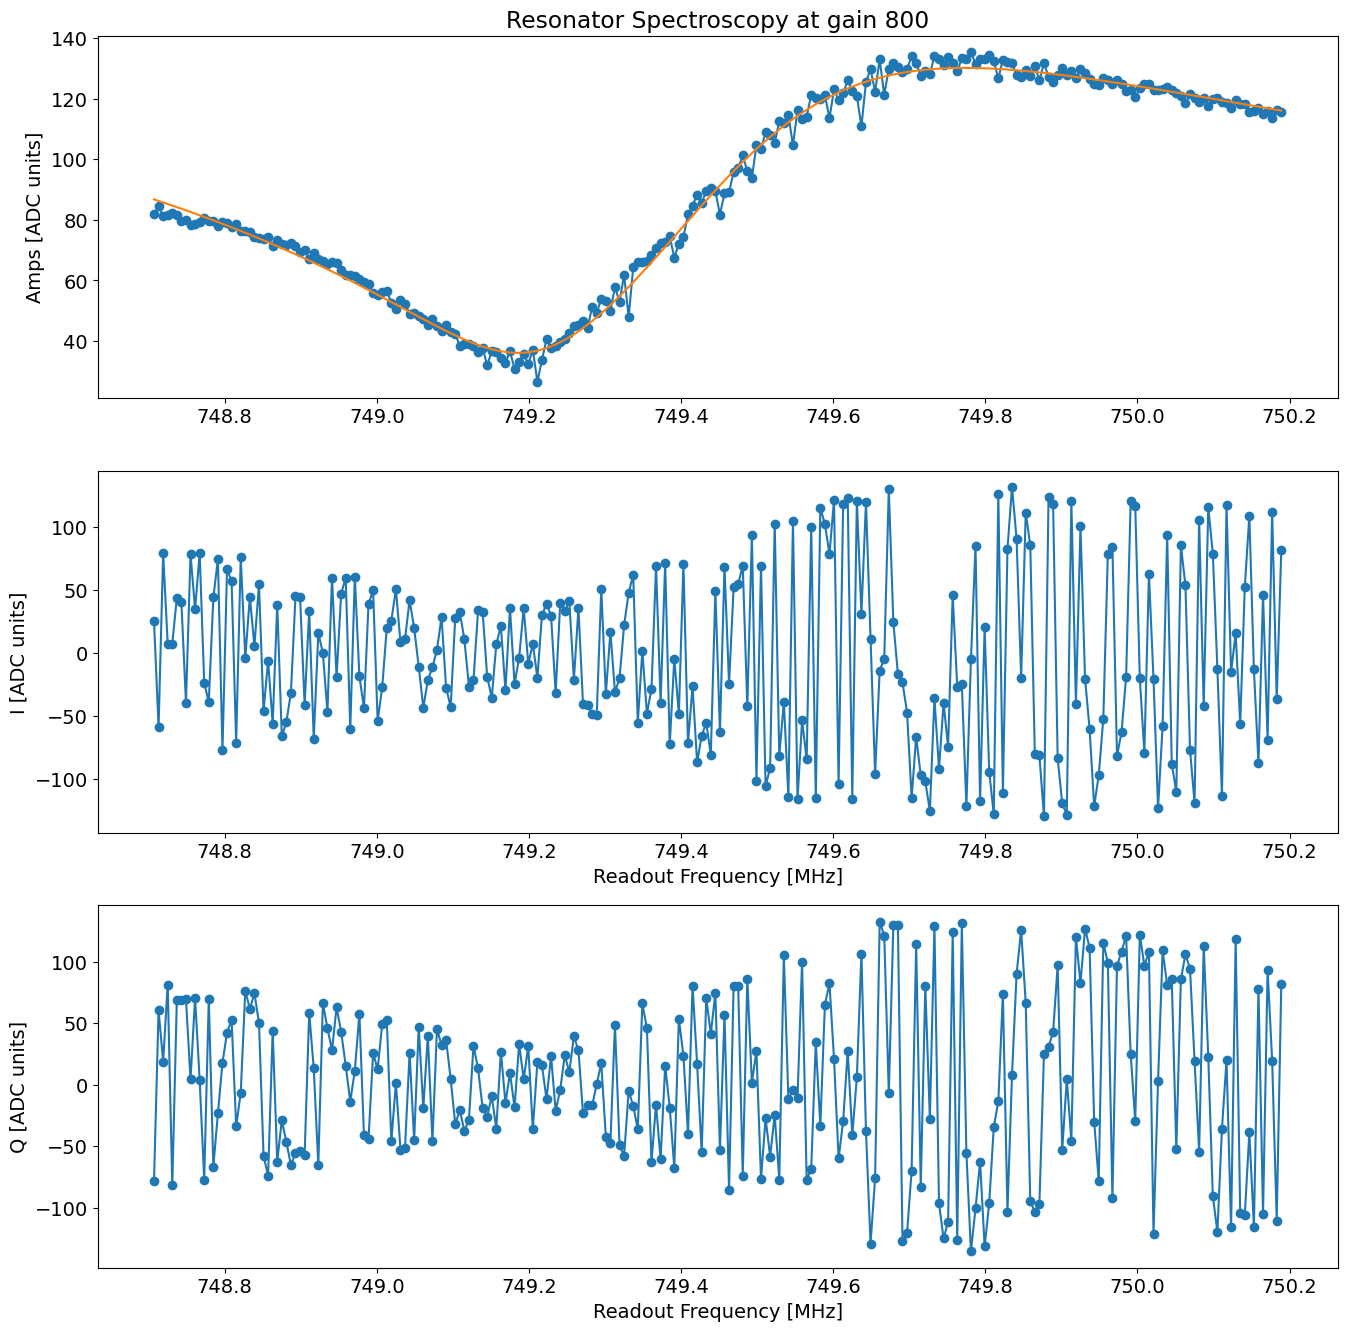

In [9]:
# Execute
# =================================
rspec_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.ResonatorSpectroscopyExperiment,
    default_expt_cfg = resspec_defaults,
    preprocessor = resspec_preproc,
    postprocessor = None, # resspec_postproc, # uncomment if you want to update the readout freq from this expt
    job_client=client,
)

if expts_to_run['res_spec']:
    rspec = rspec_runner.execute()
    rspec.display()

In [ ]:
# station.snapshot_hardware_config(update_main=False)
# station.preview_config_update()

Comparing configurations:
Parent config file: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260121-00005.yml


## Single Shot

In [12]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

Job submitted: JOB-20260122-00095 (queue position: 1)

[0.1s] Job JOB-20260122-00095: pending

[2.1s] Job JOB-20260122-00095: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00095_HistogramExperiment.h5
[WORKER] Running experiment...
 66%|████████████████████████▏            | 3276/5000 [00:06<00:03, 498.95it/s]
[28.4s] Job JOB-20260122-00095: completed
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 499.20it/s]
Unrotated:
Ig 104.5952380952381 +/- 29.382193084856233 	 Qg 28.77922077922078 +/- 23.679101545556154 	 Amp g 108.4822906324285
Ie -12.76948051948052 +/- 34.11161712943013 	 Qe 9.37987012987013 +/- 23.75865898366339 	 Amp e 15.844292233817905
Rotated:
Ig -108.0714547578363 +/- 29.642076304455312 	 Qg -11.225853533117553 +/- 23.352953407254134 	 Amp g 108.6529296476725
Ie 11.529606610389026 +/- 34.2900353814353 	 Qe -10.6962168423781 +/- 23.500420707

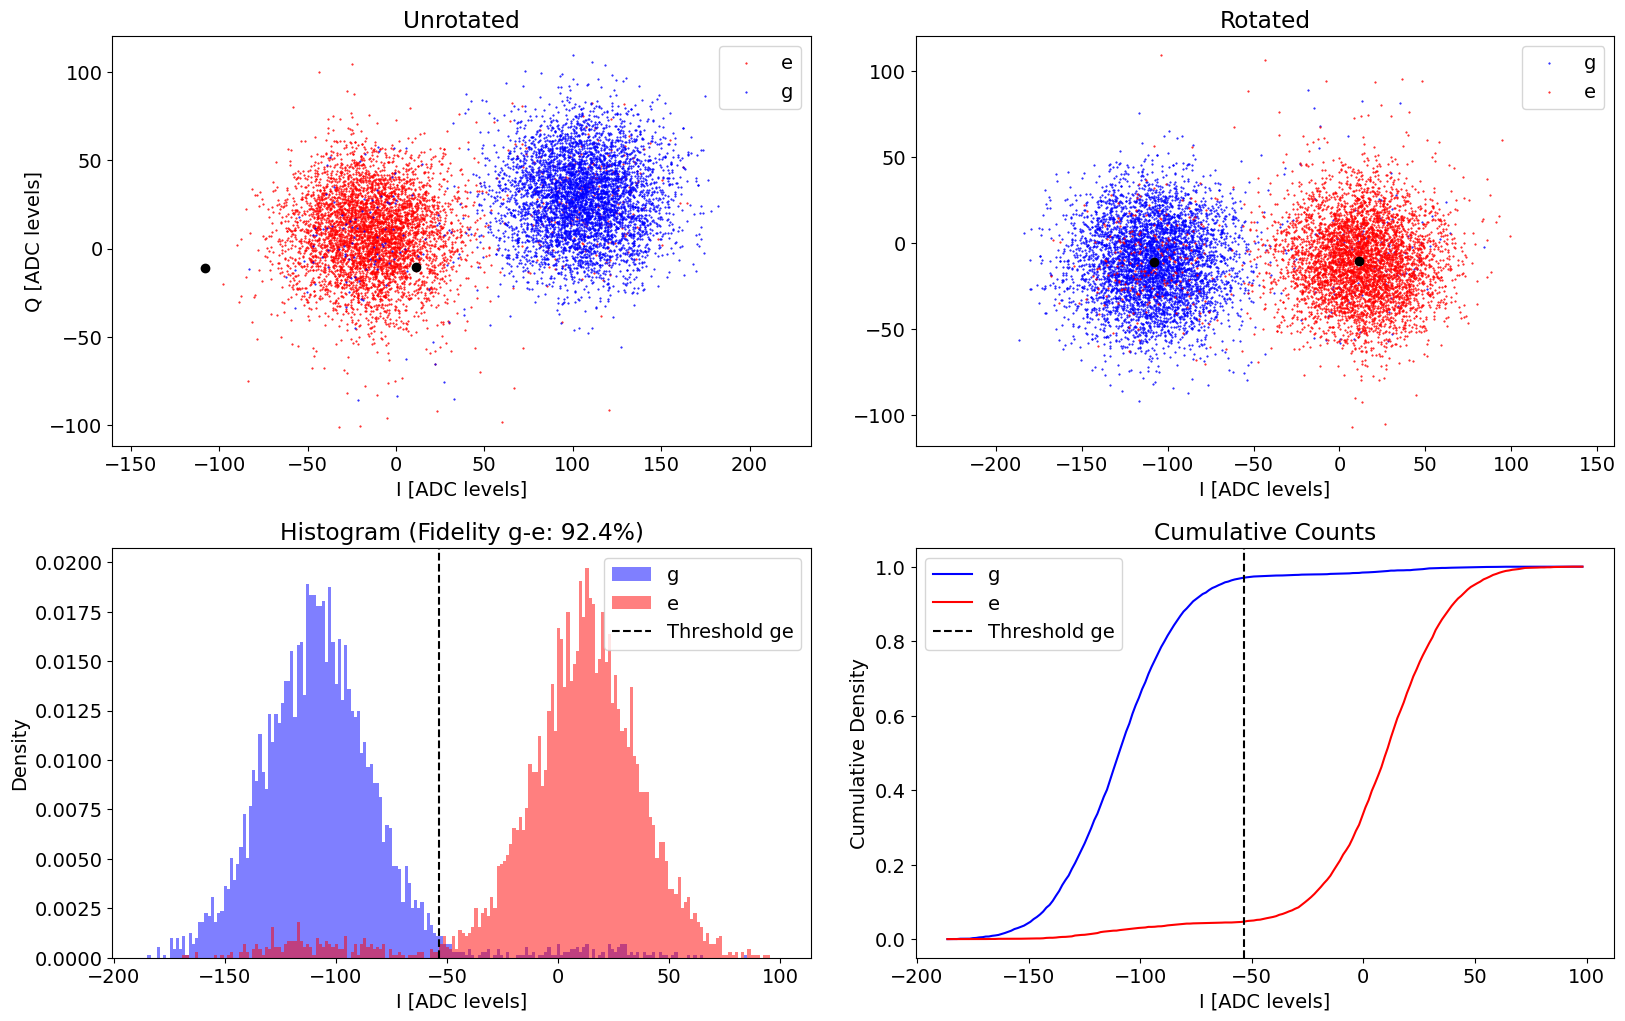

Plot saved to D:\experiments\260112_qsim_calibration_practice\plots\2026-01-22_15-51-02_histogram.png
Plot reference appended to D:\experiments\260112_qsim_calibration_practice\logs\2026-01-22.md
ge fidelity (%): 92.35847169433886
rotation angle (deg): 170.61437548195778
threshold ge: -53.404785534001746


In [13]:
# Execute
# =================================
ss_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
)

if expts_to_run['single_shot']:
    ss = ss_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        active_reset=False, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
        relax_delay=2000,
        # active_reset=True,
        # relax_delay=200,
    )
    ss.display(station)

In [15]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

[CONFIG] Reusing existing hardware_config version CFG-HW-20260122-00009
Comparing configurations:
Parent config file: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260121-00001.yml
Key 'device.readout.phase' differs:
  Old value (config1): [-70.36264047833563]
  New value (config2): [100.25173500362214]
Key 'device.readout.threshold' differs:
  Old value (config1): [-39.871969451059215]
  New value (config2): [-53.404785534001746]
Key 'device.readout.threshold_list' differs:
  Old value (config1): [[-39.871969451059215]]
  New value (config2): [[-53.404785534001746]]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9732000000000003, 0.026799999999999713, 0.0416, 0.9584]
  New value (config2): [0.9705941188237646, 0.029405881176235438, 0.04700940188037605, 0.9529905981196239]
Key 'device.readout.Ie' differs:
  Old value (config1): [22.80426330022422]
  New value (config2): [11.529606610389026]
Key 'device.readout.Ig' differs:
 

In [14]:
station.snapshot_hardware_config(update_main=True)

[CONFIG] Created new hardware_config version CFG-HW-20260122-00009
[CONFIG] Updated main hardware_config to CFG-HW-20260122-00009


'CFG-HW-20260122-00009'

## Qubit ge

### Pulse-probe

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
gespec_defaults = AttrDict(dict(    
    # start=center-span/2,  # [MHz]
    # step=span/expts,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=100,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=[0],
    qubits=[0],
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values


def gespec_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)

    span = kwargs.pop('span', 10)  # MHz
    center = kwargs.pop('center', station.hardware_cfg.device.qubit.f_ge[0])
    expts = kwargs.pop('expts', default_expt_cfg.expts)

    expt_cfg.start = center - span / 2
    expt_cfg.step = span / expts
    
    expt_cfg.update(kwargs)
    return expt_cfg

def gespec_postproc(station, expt):
    old_freq = station.hardware_cfg.device.qubit.f_ge[0]
    station.hardware_cfg.device.qubit.f_ge = [expt.data['fit_avgi'][2]]
    print(f'Updated qubit frequency from {old_freq} to {station.hardware_cfg.device.qubit.f_ge[0]}!')

pulssing on channel:  2
qubit register page: 1, frequency register: 22


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\260101_qsim\data\00019_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3562.548599486454, HWHM -0.34812503871900574
Found peak in I at [MHz] 3562.5523835168246, HWHM -0.3442308722672553
Found peak in Q at [MHz] 3562.51963427988, HWHM 0.3641849174590421


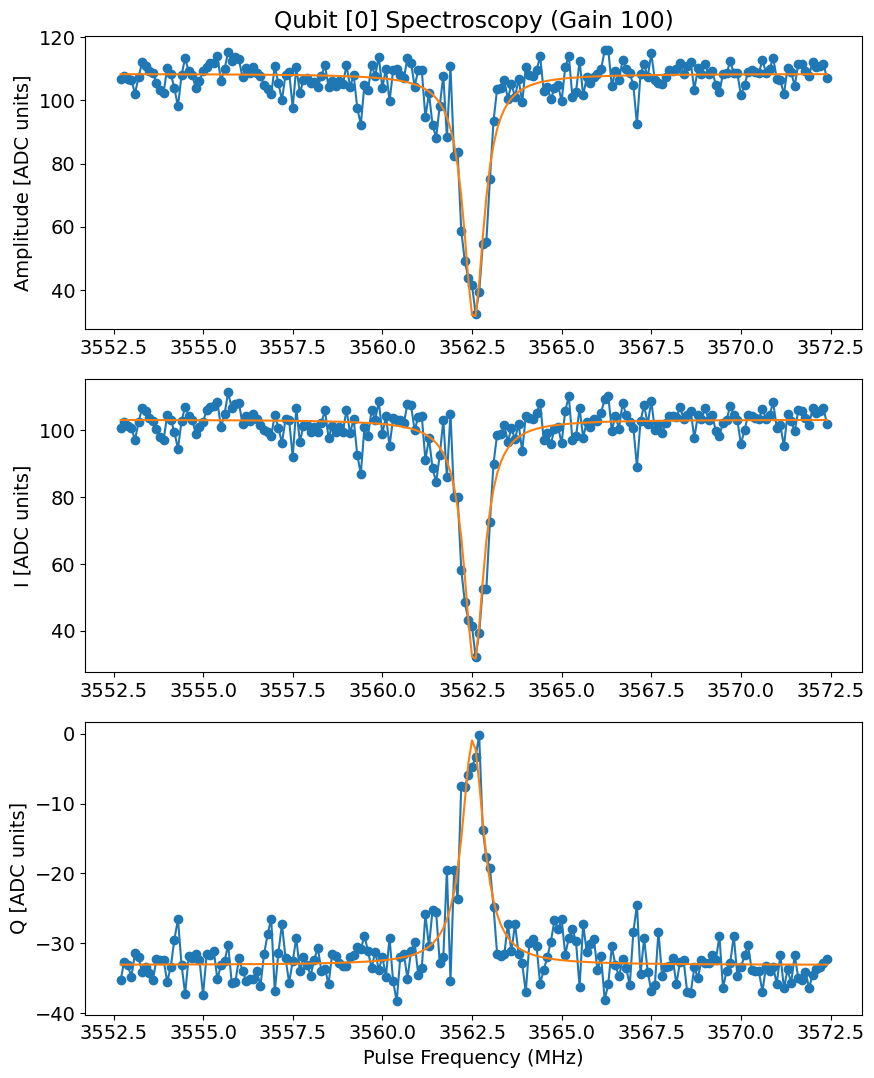

Updated qubit frequency from 3562.596238603594 to 3562.5523835168246!


In [ ]:
# Execute
# =================================
gespec_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.PulseProbeSpectroscopyExperiment,
    default_expt_cfg = gespec_defaults,
    preprocessor = gespec_preproc,
    postprocessor = gespec_postproc,
    job_client=client,
)

if expts_to_run['pulse_probe_ge']:
    gespec = gespec_runner.execute()
    gespec.display()

In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

### T2 Ramsey

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
geramsey_defaults = AttrDict(dict(
    ramsey_freq=0.2,  # [MHz]
    start=0.01, # us
    step=0.5,
    expts=101,
    reps=200,
    rounds=1,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    if_ef=False,
    ef_init=True, # redundant
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=200
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def geramsey_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if expt_cfg.if_ef:
        checkEF = True
        qubit_ge_init = True if expt_cfg.ef_init else False
        qubit_ge_after = True if expt_cfg.ef_init else False
    expt_cfg.checkEF = checkEF
    expt_cfg.qubit_ge_init = qubit_ge_init
    expt_cfg.qubit_ge_after = qubit_ge_after

    expt_cfg.prepulse = False if expt_cfg.pre_sweep_pulse is None else True if expt_cfg.prepulse is None else expt_cfg.prepulse,
    expt_cfg.postpulse = False if expt_cfg.post_sweep_pulse is None else True if expt_cfg.postpulse is None else expt_cfg.postpulse,
    
    return expt_cfg

def geramsey_postproc(station, expt):
    old_freq = station.hardware_cfg.device.qubit.f_ge[0]
    station.hardware_cfg.device.qubit.f_ge = [
        station.hardware_cfg.device.qubit.f_ge[0] + min(expt.data['f_adjust_ramsey_avgi'])
    ]
    print(f'Updated qubit frequency from {old_freq} to {station.hardware_cfg.device.qubit.f_ge[0]}!')

fge is  3562.613351269981
fef is  3419.0415164961432


  0%|          | 0/20200 [00:00<?, ?it/s]

No echoes in the data
Saving D:\experiments\260112_qsim_calibration_practice\data\00026_RamseyExperiment.h5
Current pi pulse frequency: 3562.613351269981
Fit frequency from I [MHz]: 0.20259015484996745 +/- 0.0001843606621277634
Suggested new pi pulse frequency from fit I [MHz]:
 	3562.610761115131
 	3563.015941424831
T2 Ramsey from fit I [us]: 261.8132779880607
Fit frequency from Q [MHz]: 0.047095966321008174 +/- 0.006084899168265302
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3562.7662553036603
 	3562.860447236302
T2 Ramsey from fit Q [us]: 24.45341996316469


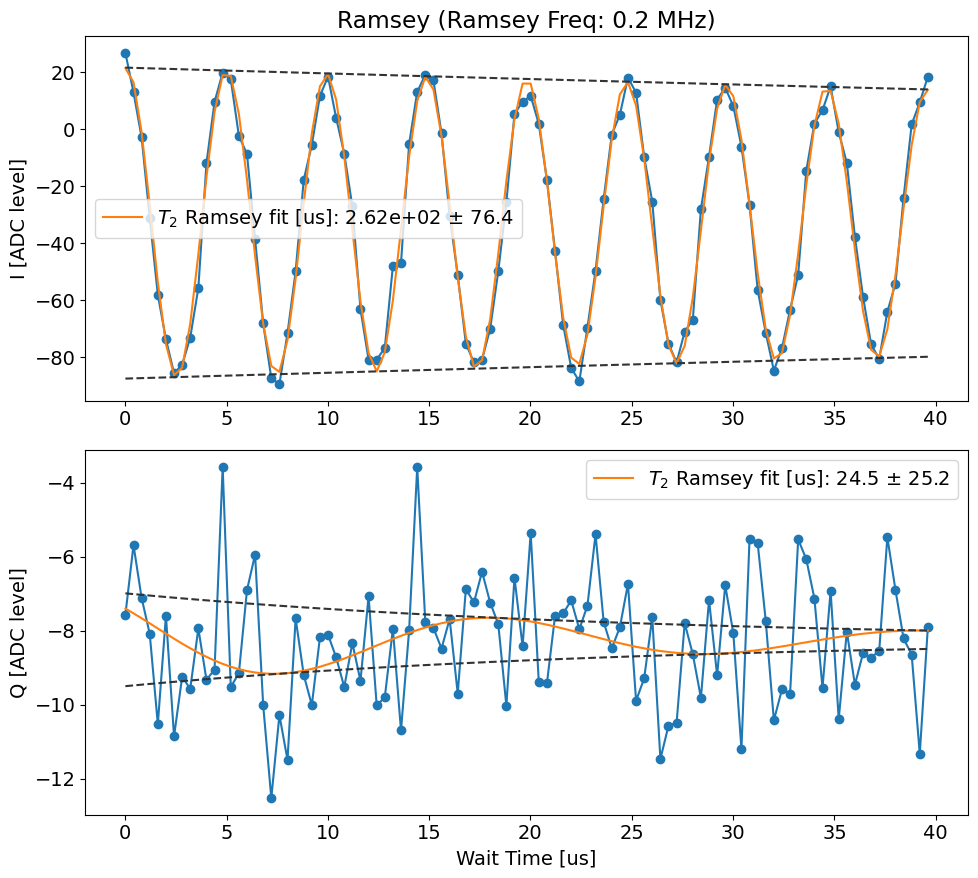

Updated qubit frequency from 3562.613351269981 to 3562.610761115131!


In [ ]:
# Execute
# =================================
geramsey_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.RamseyExperiment,
    default_expt_cfg = geramsey_defaults,
    preprocessor = geramsey_preproc,
    postprocessor = geramsey_postproc,
    job_client=client,
)

if expts_to_run['t2_ge']:
    geramsey = geramsey_runner.execute(
        ramsey_freq = 0.2,
        step=0.4,
        active_reset=False,
        relax_delay=2500,
        postprocess=True,
        if_ef=False,
    )
    geramsey.display()

In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

  0%|          | 0/30200 [00:00<?, ?it/s]

Attempted to init fitparam 4 to -38.85972764542301, which is out of bounds -12.932359307359308 to -4.106612554112554. Instead init to -8.51948593073593
Attempted to init fitparam 4 to -8.51948593073593, which is out of bounds 5.834305708346742 to 92.99063326600597. Instead init to 49.41246948717636
Saving D:\experiments\260112_qsim_calibration_practice\data\00008_AmplitudeRabiExperiment.h5
Pi gain from avgi data [dac units]: 3289
	Pi/2 gain from avgi data [dac units]: 1629
Pi gain from avgq data [dac units]: 3268
	Pi/2 gain from avgq data [dac units]: 786


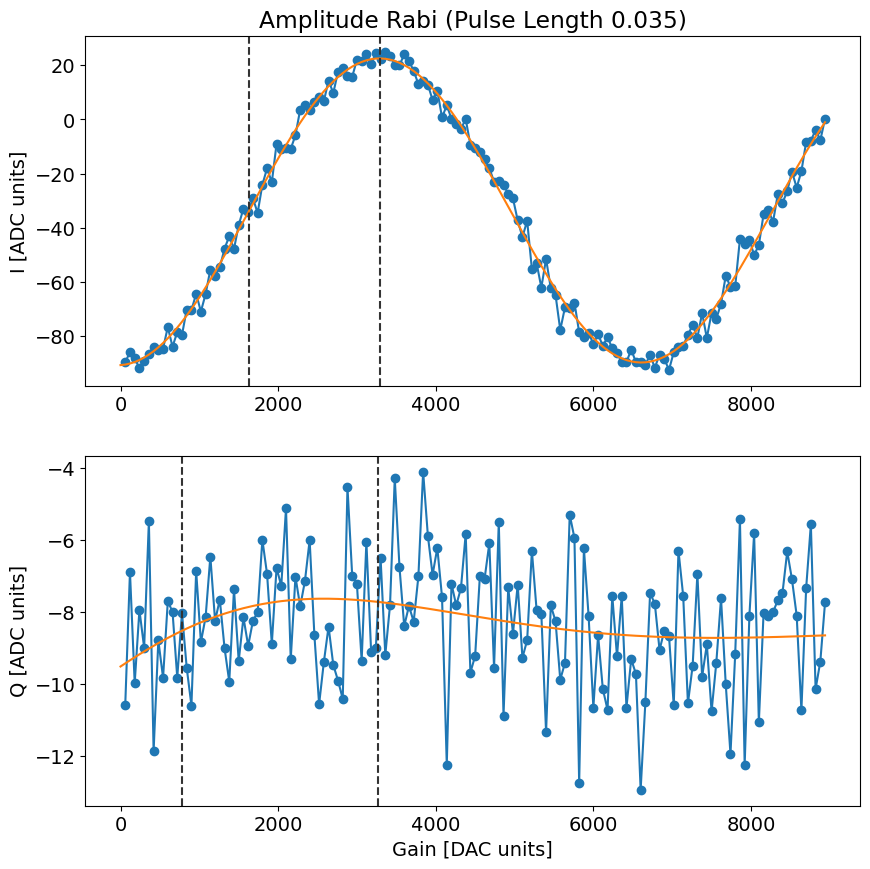

Updated qubit ge pi and hpi gaussian gain!
fge is  3562.610761115131
fef is  3419.0415164961432


  0%|          | 0/20200 [00:00<?, ?it/s]

No echoes in the data
Saving D:\experiments\260112_qsim_calibration_practice\data\00027_RamseyExperiment.h5
Current pi pulse frequency: 3562.610761115131
Fit frequency from I [MHz]: 0.20022782082373075 +/- 0.0001778466326411408
Suggested new pi pulse frequency from fit I [MHz]:
 	3562.6105332943075
 	3563.0109889359546
T2 Ramsey from fit I [us]: 418.0283426122109
Fit frequency from Q [MHz]: 0.20176082701121514 +/- 0.0023276508272821878
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3562.6090002881197
 	3563.012521942142
T2 Ramsey from fit Q [us]: 118.2657395848334


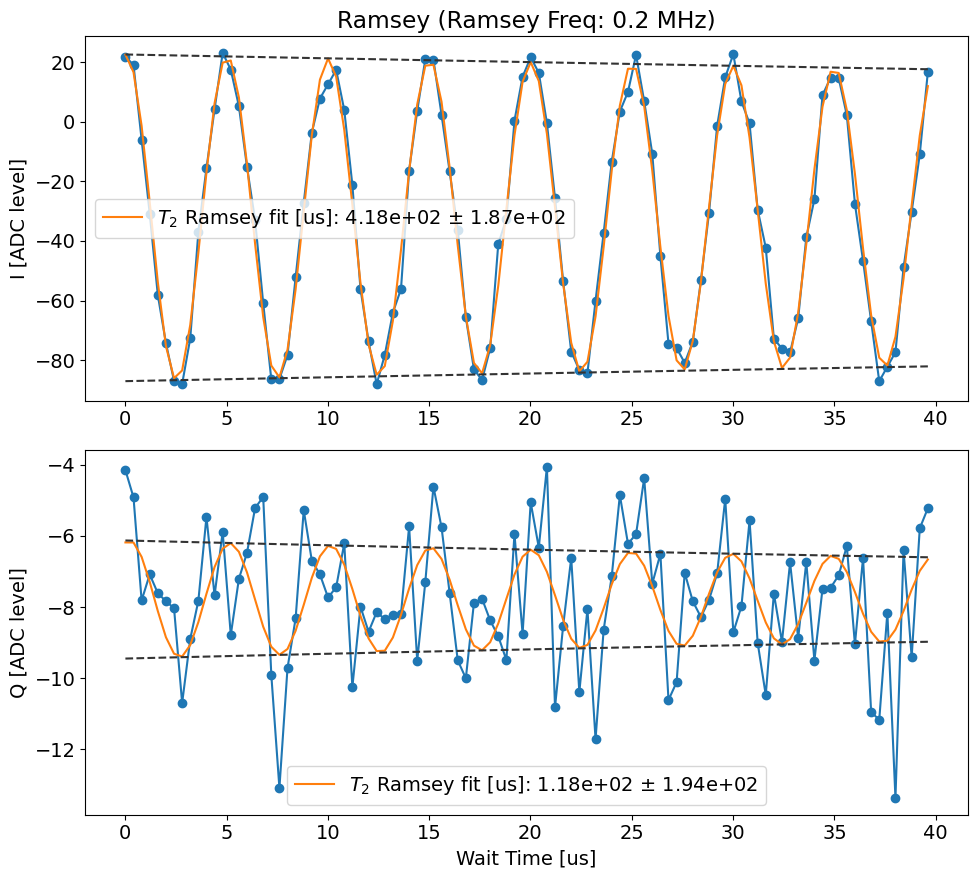

Updated qubit frequency from 3562.610761115131 to 3562.6105332943075!


In [ ]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.AmplitudeRabiExperiment,
    default_expt_cfg = amprabi_defaults,
    preprocessor = amprabi_preproc,
    postprocessor = amprabi_postproc,
    job_client=client,
)

if expts_to_run['amplitude_ge']:
    amprabi = amprabi_runner.execute(
        relax_delay=2500,
        postprocess=True,
    )
    amprabi.display()

    #After amplitude calibration, do another T2 Ramsey to fine tune frequency
    #Added by Jonginn, as a part of practice
    #Please remove if the below code causes any problem.
    t2_ramsey_ge_after_amp = geramsey_runner.execute(
        ramsey_freq = 0.2,
        step = 0.4,
        active_reset = True,
        relax_delay=250,
    )
    t2_ramsey_ge_after_amp.display()


In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

### T1

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
t1_ge_defaults = AttrDict(dict(
    start=0,
    step=20,
    expts=100,
    reps=100,
    rounds=1,
    qubit=0,
    qubit_ef=False,
    normalize=False,
    relax_delay=2500,
))

def t1_ge_postproc(station, expt):
    station.hardware_cfg.device.qubit.T1 = [expt.data['fit_avgi'][3]]
    print('Updated qubit T1!')


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving D:\experiments\260112_qsim_calibration_practice\data\00005_T1Experiment.h5
Fit T1 avgi [us]: 393.0070389378491
Fit T1 avgq [us]: 725.2991444687509


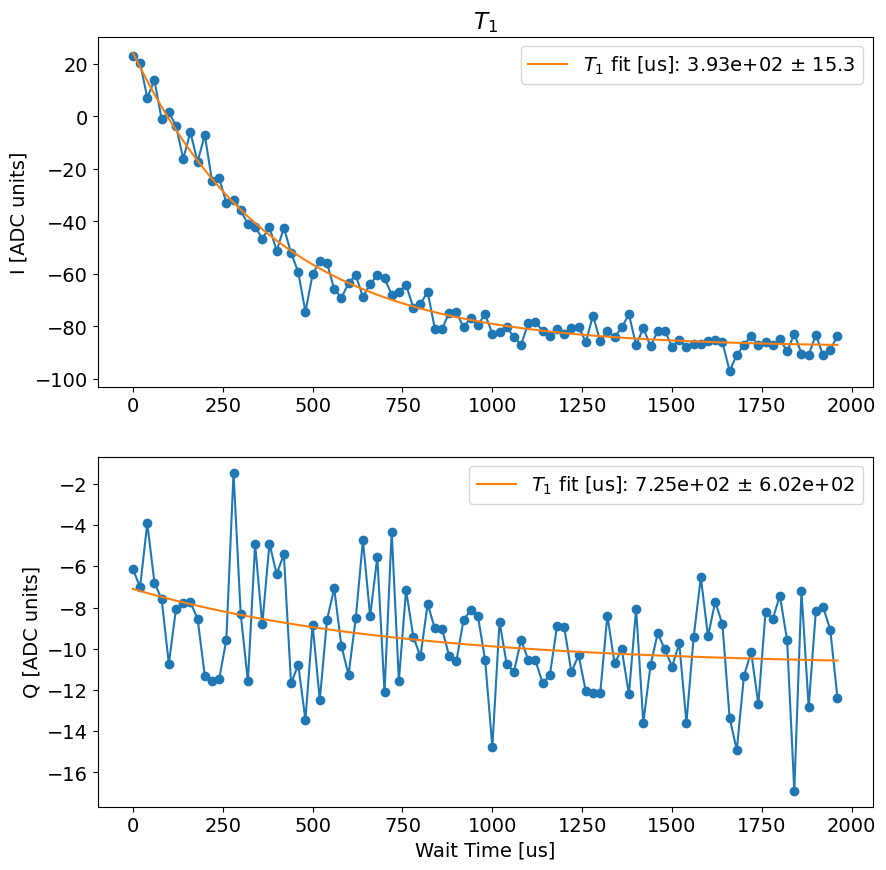

Updated qubit T1!


In [ ]:
# Execute
# =================================
t1_ge_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.single_qubit.t1.T1Experiment,
    default_expt_cfg=t1_ge_defaults,
    postprocessor=t1_ge_postproc,
    job_client=client,
)

if expts_to_run['t1_ge']:
    t1_ge = t1_ge_runner.execute()
    t1_ge.display()

In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

## Qubit ef

### Pulse-probe

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
efspec_defaults = AttrDict(dict(
    start=3415,
    step=0.05,
    expts=500,
    reps=200,
    rounds=1,
    length=1,
    gain=100,
    qubit_f=False,
    qubit=0,
    cavity_drive=False,
    wait_qubit=False,
    relax_delay=500,
))

def efspec_postproc(station, expt):
    old_freq = station.hardware_cfg.device.qubit.f_ef[0]
    station.hardware_cfg.device.qubit.f_ef = [expt.data['fit_avgi'][2]]
    print(f'Updated qubit ef frequency from {old_freq} to {station.hardware_cfg.device.qubit.f_ef[0]}!')


  0%|          | 0/100000 [00:00<?, ?it/s]

Saving D:\experiments\260112_qsim_calibration_practice\data\00004_PulseProbeEFSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3419.016401019646, HWHM -0.4554925231687473
Found peak in I at [MHz] 3419.015754059691, HWHM -0.38994888760706525
Found peak in Q at [MHz] 3419.0221597934615, HWHM -0.40329556360989866


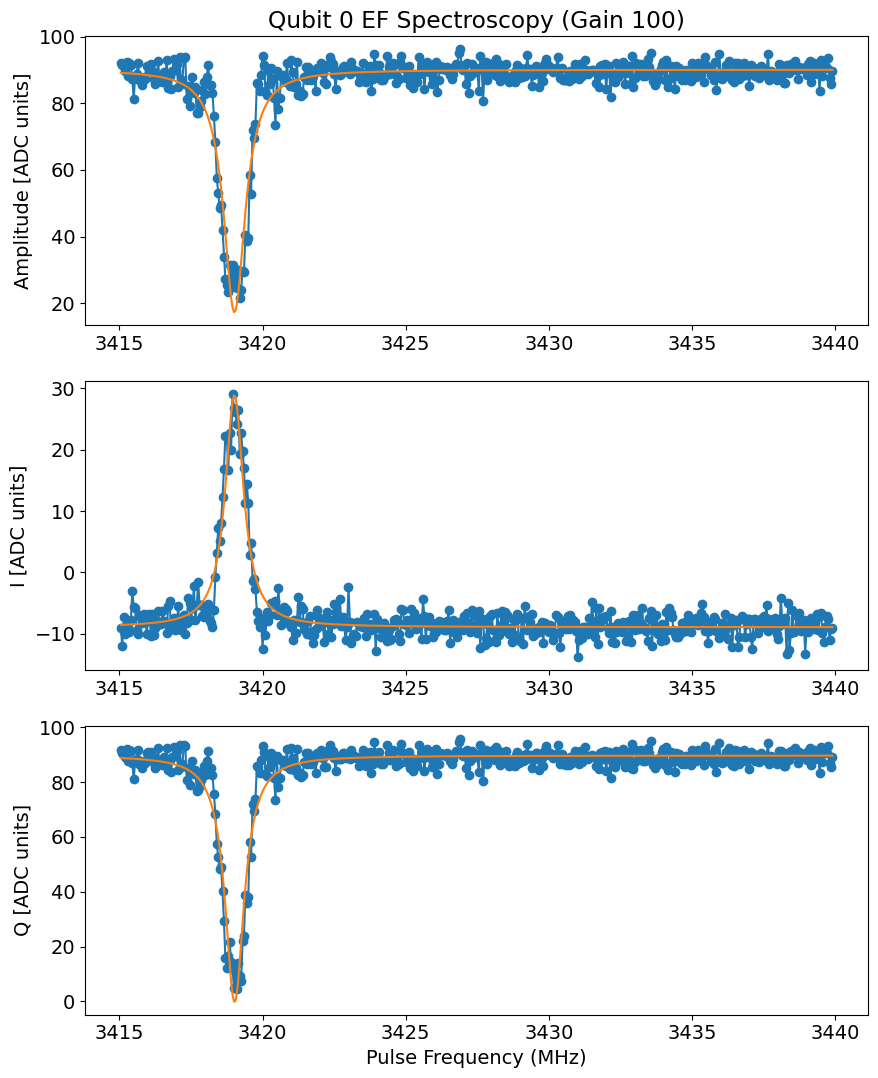

Updated qubit ef frequency from 3419.0415164961432 to 3419.015754059691!


In [ ]:
# Execute
# =================================
efspec_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.PulseProbeEFSpectroscopyExperiment,
    default_expt_cfg=efspec_defaults,
    postprocessor=efspec_postproc,
    job_client=client,
)

if expts_to_run['pulse_probe_ef']:
    qspec_ef = efspec_runner.execute()
    qspec_ef.display()

### T2 Ramsey

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
# Reuse ge defaults but with if_ef=True
eframsey_defaults = AttrDict(deepcopy(geramsey_defaults))
eframsey_defaults.if_ef = True
eframsey_defaults.ef_init = True
eframsey_defaults.ramsey_freq = 3  # Typical ef ramsey frequency

def eframsey_postproc(station, expt):
    old_freq = station.hardware_cfg.device.qubit.f_ef[0]
    station.hardware_cfg.device.qubit.f_ef = [
        station.hardware_cfg.device.qubit.f_ef[0] + min(expt.data['f_adjust_ramsey_avgi'])
    ]
    print(f'Updated qubit ef frequency from {old_freq} to {station.hardware_cfg.device.qubit.f_ef[0]}!')


fge is  3562.6105332943075
fef is  3419.015754059691


  0%|          | 0/20200 [00:00<?, ?it/s]

No echoes in the data
Saving D:\experiments\260112_qsim_calibration_practice\data\00028_RamseyExperiment.h5
Current pi pulse frequency: 3419.015754059691
Fit frequency from I [MHz]: 0.48062026743084274 +/- 0.000742730949200538
Suggested new pi pulse frequency from fit I [MHz]:
 	3419.0351337922602
 	3419.996374327122
T2 Ramsey from fit I [us]: 95.93279720097566
Fit frequency from Q [MHz]: 0.4810249791895802 +/- 0.0008053359257081703
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3419.0347290805016
 	3419.9967790388805
T2 Ramsey from fit Q [us]: 137.5865838573234


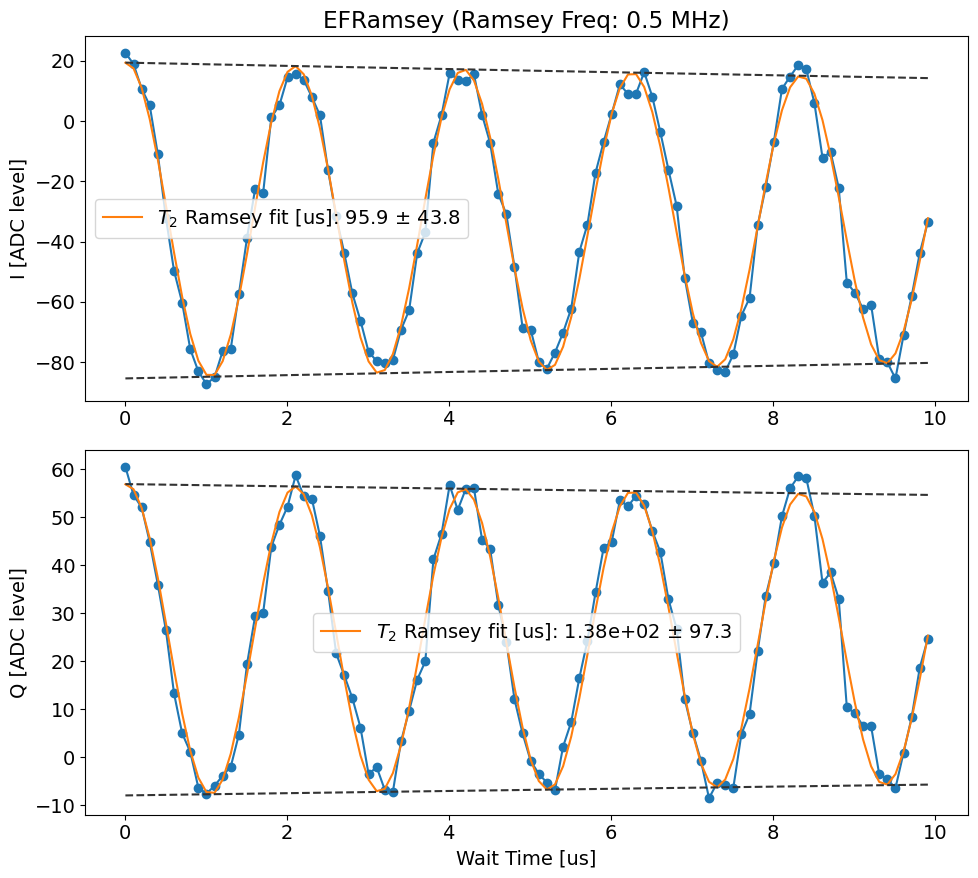

Updated qubit ef frequency from 3419.015754059691 to 3419.0351337922602!


In [ ]:
# Execute
# =================================
eframsey_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.RamseyExperiment,
    default_expt_cfg=eframsey_defaults,
    preprocessor=geramsey_preproc,  # Reuse ge preprocessor
    postprocessor=eframsey_postproc,
    job_client=client,
)

if expts_to_run['t2_ef']:
    t2ramsey_ef = eframsey_runner.execute(
        ramsey_freq=0.5,
        step = 0.1,
        relax_delay=2500,
        active_reset=True,
    )
    t2ramsey_ef.display()

In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
# Reuse ge defaults but with if_ef=True
efamprabi_defaults = AttrDict(deepcopy(amprabi_defaults))
efamprabi_defaults.if_ef = True
efamprabi_defaults.step = 40  # Typical ef amplitude step
efamprabi_defaults.expts = 150

def efamprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ef.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ef.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')


  0%|          | 0/30000 [00:00<?, ?it/s]

Attempted to init fitparam 4 to -31.238300216450213, which is out of bounds -11.694707792207792 to 60.27384199134199. Instead init to 24.289567099567098
Attempted to init fitparam 4 to 24.289567099567098, which is out of bounds 35.946989477509874 to 94.14184385848756. Instead init to 65.04441666799872
Saving D:\experiments\260112_qsim_calibration_practice\data\00009_AmplitudeRabiExperiment.h5
Pi gain from avgi data [dac units]: 3038
	Pi/2 gain from avgi data [dac units]: 1514
Pi gain from avgq data [dac units]: 3038
	Pi/2 gain from avgq data [dac units]: 1527


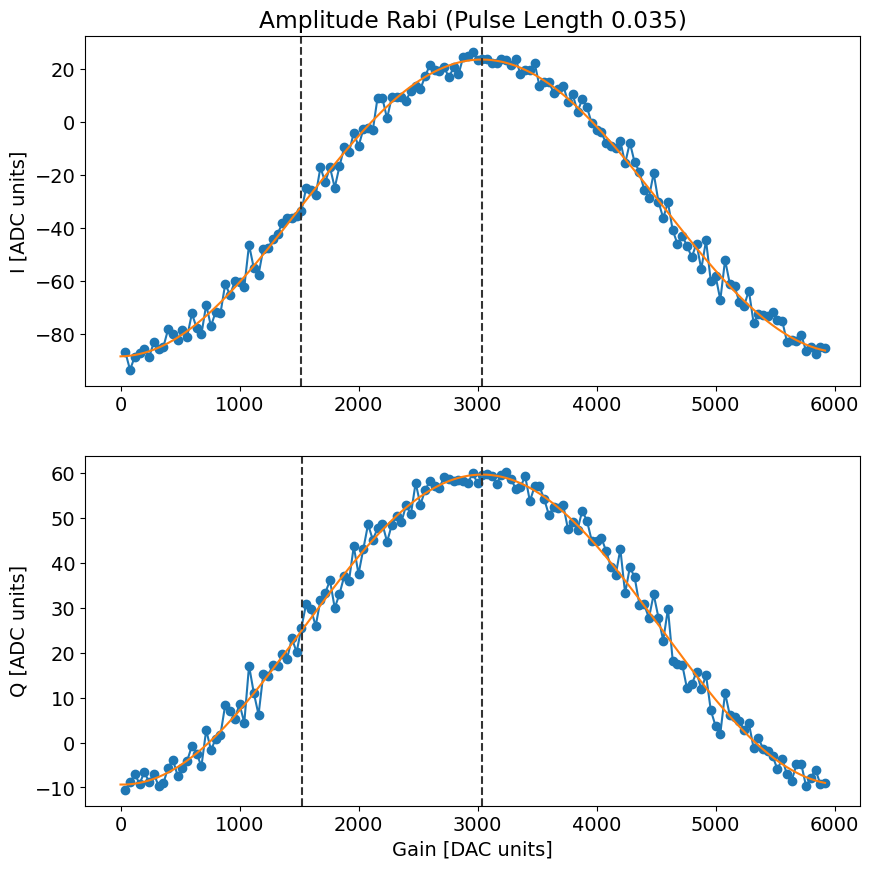

Updated qubit ef pi and hpi gaussian gain!
fge is  3562.6105332943075
fef is  3419.0351337922602


  0%|          | 0/20200 [00:00<?, ?it/s]

No echoes in the data
Saving D:\experiments\260112_qsim_calibration_practice\data\00029_RamseyExperiment.h5
Current pi pulse frequency: 3419.0351337922602
Fit frequency from I [MHz]: 0.4991217313182372 +/- 0.001361811899682974
Suggested new pi pulse frequency from fit I [MHz]:
 	3419.036012060942
 	3420.0342555235784
T2 Ramsey from fit I [us]: 16.76269934574044
Fit frequency from Q [MHz]: 0.5005322568083582 +/- 0.0014684469429258014
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3419.0346015354517
 	3420.035666049069
T2 Ramsey from fit Q [us]: 16.60380258639506


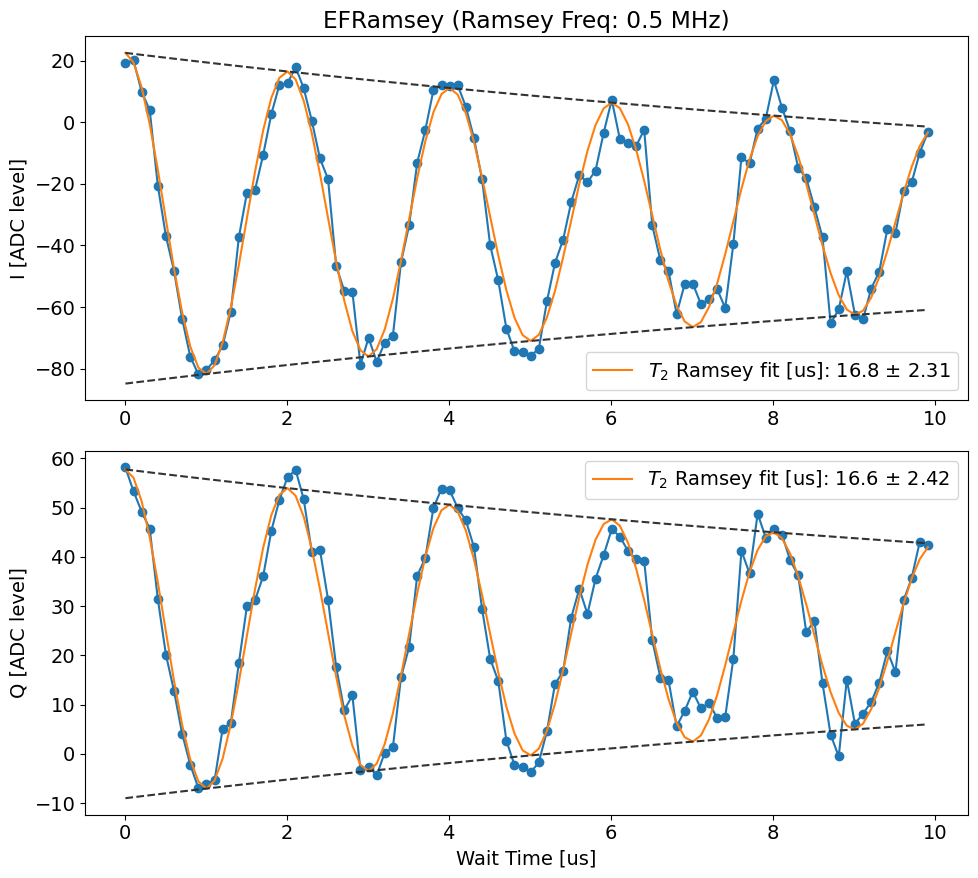

Updated qubit ef frequency from 3419.0351337922602 to 3419.036012060942!


In [ ]:
# Execute
# =================================
efamprabi_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.AmplitudeRabiExperiment,
    default_expt_cfg=efamprabi_defaults,
    preprocessor=amprabi_preproc,  # Reuse ge preprocessor
    postprocessor=efamprabi_postproc,
    job_client=client,
)

if expts_to_run['amplitude_ef']:
    amprabi_ef = efamprabi_runner.execute(
                relax_delay=2500,
    )
    amprabi_ef.display()
    
    # After amplitude calibration, do another T2 Ramsey to fine tune frequency
    t2_ramsey_ef_after_amp = eframsey_runner.execute(
        ramsey_freq=0.5,
        step = 0.1,
        relax_delay=2500,
    )
    t2_ramsey_ef_after_amp.display()

In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

### T1

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
t1_ef_defaults = AttrDict(dict(
    start=0,
    step=5,
    expts=100,
    reps=50,
    rounds=1,
    qubit=0,
    qubit_ef=True,
    normalize=False,
    relax_delay=2500,
))

def t1_ef_postproc(station, expt):
    station.hardware_cfg.device.qubit.T1_ef = [expt.data['fit_avgq'][3]]
    print('Updated qubit T1 ef!')


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving D:\experiments\260112_qsim_calibration_practice\data\00007_T1Experiment.h5
Fit T1 avgi [us]: 77.17010496621927
Fit T1 avgq [us]: 267.2742414577797


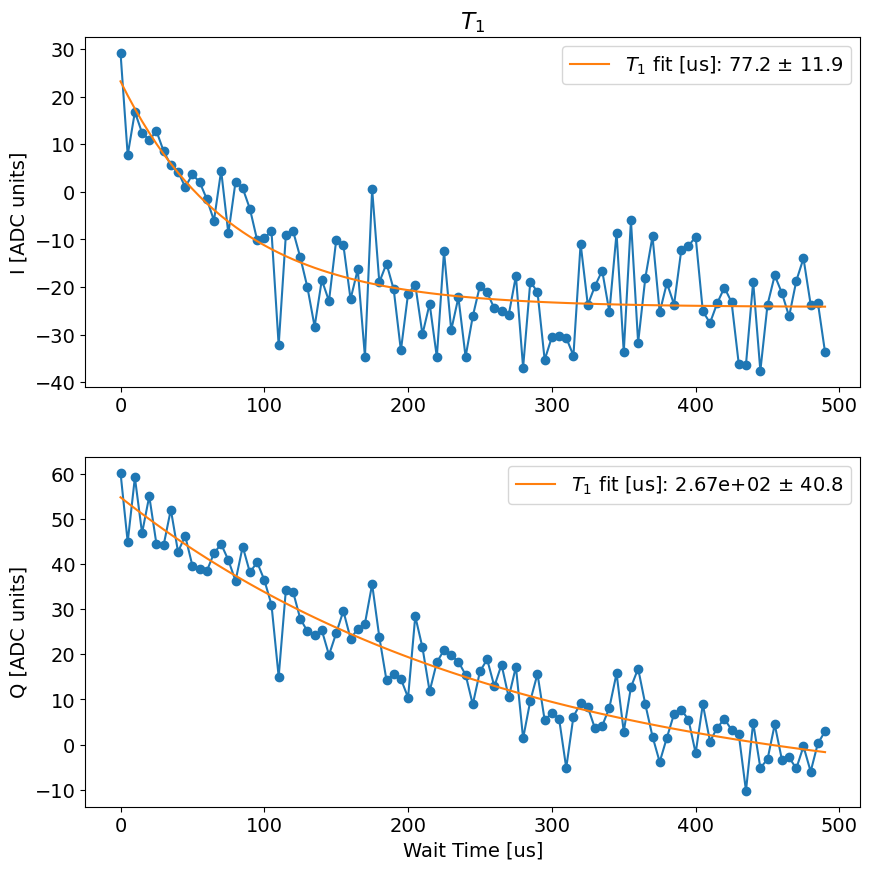

Updated qubit T1 ef!


In [ ]:
# Execute
# =================================
t1_ef_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.T1Experiment,
    default_expt_cfg=t1_ef_defaults,
    postprocessor=t1_ef_postproc,
    job_client=client,
)

if expts_to_run['t1_ef']:
    t1_ef = t1_ef_runner.execute()
    t1_ef.display()

In [ ]:
station.snapshot_hardware_config(update_main=False)
station.preview_config_update()

# Manipulate

## Spectroscopy

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
f0g1spec_defaults = AttrDict(dict(
    start=None,  # Will be computed in preprocessor from ds_storage
    step=0.2,
    expts=200,
    reps=100,
    rounds=1,
    length=1,
    gain=3000,
    pulse_type='gaussian',
    qubit_f=True,
    qubits=[0],
    prepulse=False,
    relax_delay=200,
))

def f0g1spec_preproc(station, default_expt_cfg, man_mode_no=1, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.man_mode_no = man_mode_no  # Store for postprocessor
    expt_cfg.update(kwargs)
    
    # Compute start frequency from dataset if not provided
    if expt_cfg.start is None:
        expt_cfg.start = station.ds_storage.get_freq('M' + str(man_mode_no)) - 20
    
    return expt_cfg

def f0g1spec_postproc(station, expt):
    man_mode_no = expt.cfg.expt.man_mode_no
    station.ds_storage.update_freq('M' + str(man_mode_no), expt.data['fit_avgi'][2])
    station.hardware_cfg.device.multiphoton['pi']['fn-gn+1']['frequency'][0] = expt.data['fit_avgi'][2]
    print(f"Updated man f0g1 freq to: {station.ds_storage.get_freq('M' + str(man_mode_no))}")


In [7]:
# station.yoko_coupler.ramp_current(0.5e-3, sweeprate=0.0001)

Running pulse probe f0g1 for mode 1


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\260112_qsim_calibration_practice\data\00004_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 1998.8187776794116, HWHM 1.943884607782846
Found peak in I at [MHz] 2000.1463743710858, HWHM -0.410538492642002
Found peak in Q at [MHz] 2000.1539236188855, HWHM -0.4086696340960341


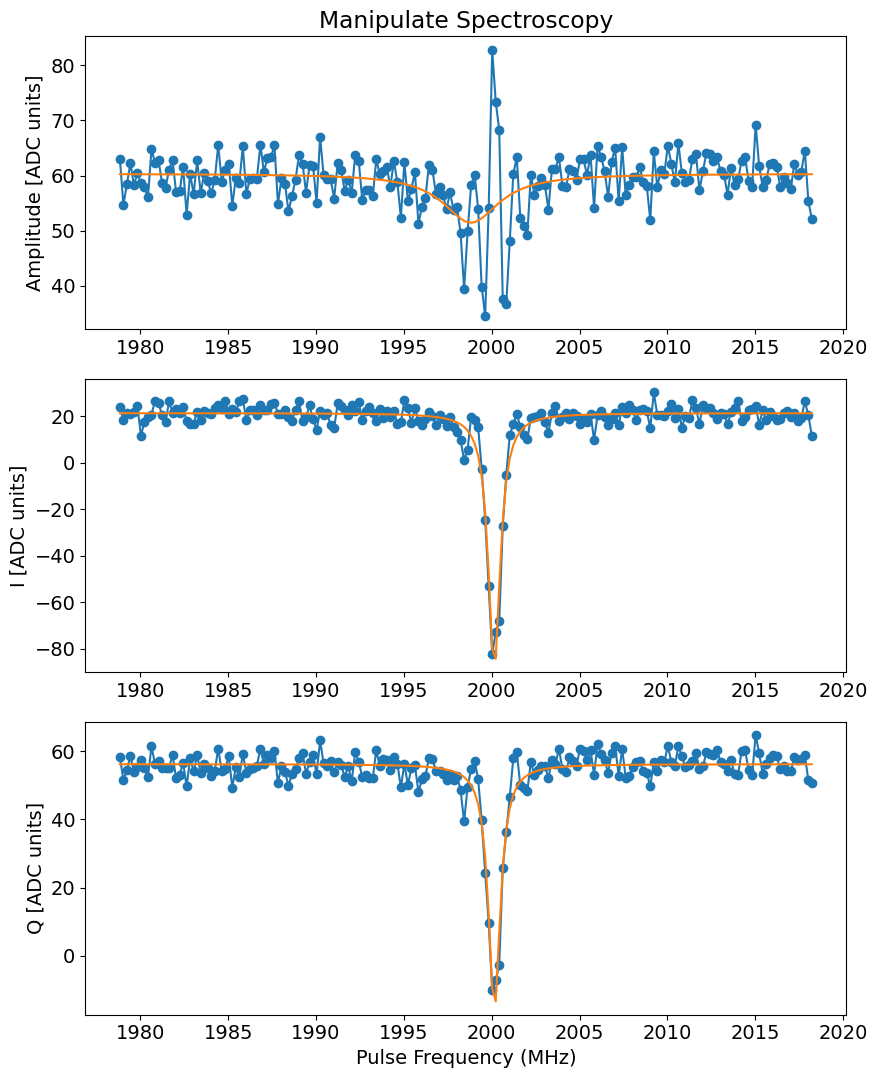

Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated man f0g1 freq to: 2000.1463743710858


In [ ]:
# Execute
# =================================
f0g1spec_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.PulseProbeF0g1SpectroscopyExperiment,
    default_expt_cfg=f0g1spec_defaults,
    preprocessor=f0g1spec_preproc,
    postprocessor=f0g1spec_postproc,
    job_client=client,
)

man_specs = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['pulse_probe_f0g1']:
        print(f'Running pulse probe f0g1 for mode {i+1}')
        man_specs[i] = f0g1spec_runner.execute(
            man_mode_no=i+1,
            go_kwargs=dict(progress=True),
            relax_delay=2500,
        )
        man_specs[i].display()


In [ ]:
station.snapshot_hardware_config(update_main=False)
station.snapshot_man1_storage_swap(update_main=False)
station.preview_config_update()

## Find Frequency (Chevron)


In [ ]:
chevron_defaults = AttrDict(dict(
    start=2, # time start in us
    step=0.1, # time step in us
    expts=25, # number of time points
    reps=100,
    rounds=1,
    qubits=[0],
    gain=None, # Leave as None to use current value in dataset
    ramp_sigma=0.005,
    use_arb_waveform=False,
    pi_ge_before=True,
    pi_ef_before=True,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    check_man_reset=[False, 0],
    check_man_reset_pi=[],
    prepulse=False,
    pre_sweep_pulse=[],
    err_amp_reps=0,
    swap_lossy=False,
))

# Postprocessor: extracts result from mother experiment and updates config
def my_postproc(station, mother_expt):
    """
    Postprocessor for chevron sweep.
    
    Args:
        station: MultimodeStation instance
        mother_expt: The mother experiment with 2D data and analysis results
    """
    # Access the chevron analysis results
    if hasattr(mother_expt, '_chevron_analysis') and mother_expt._chevron_analysis:
        analysis = mother_expt._chevron_analysis
        best_freq = analysis.results.get('best_frequency_contrast')
        
        if best_freq:
            print(f"Best frequency found: {best_freq:.4f} MHz")
            
            # Update dataset and config
            station.ds_storage.update_freq('M1', best_freq)
            station.hardware_cfg.device.multiphoton['pi']['fn-gn+1']['frequency'][0] = best_freq
            print(f"Updated M1 frequency to {best_freq:.4f} MHz")
    else:
        print("No chevron analysis available")


runner = SweepRunner(
    station=station,
    ExptClass=meas.LengthRabiGeneralF0g1Experiment,
    default_expt_cfg=chevron_defaults,
    sweep_param='freq',
    live_plot=False,
    # preprocessor=my_preproc,
    postprocessor=my_postproc,
    job_client=client,
)

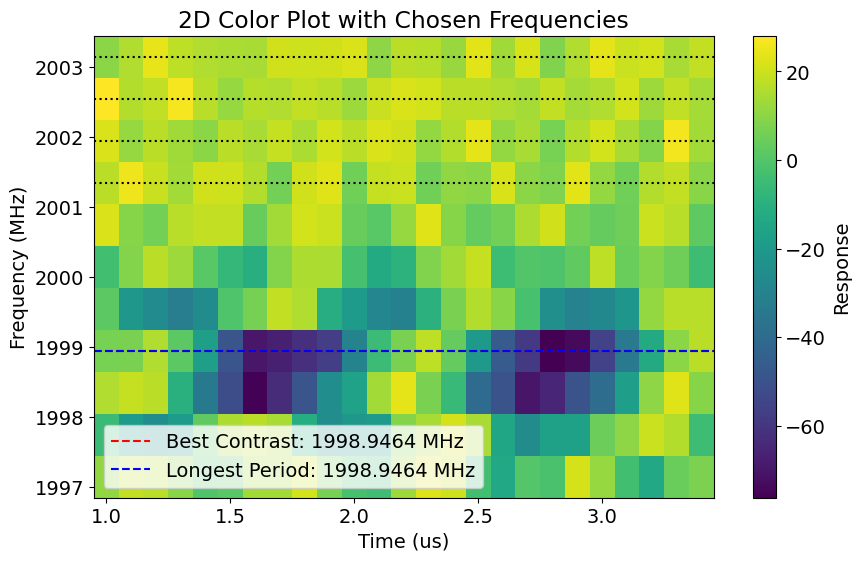

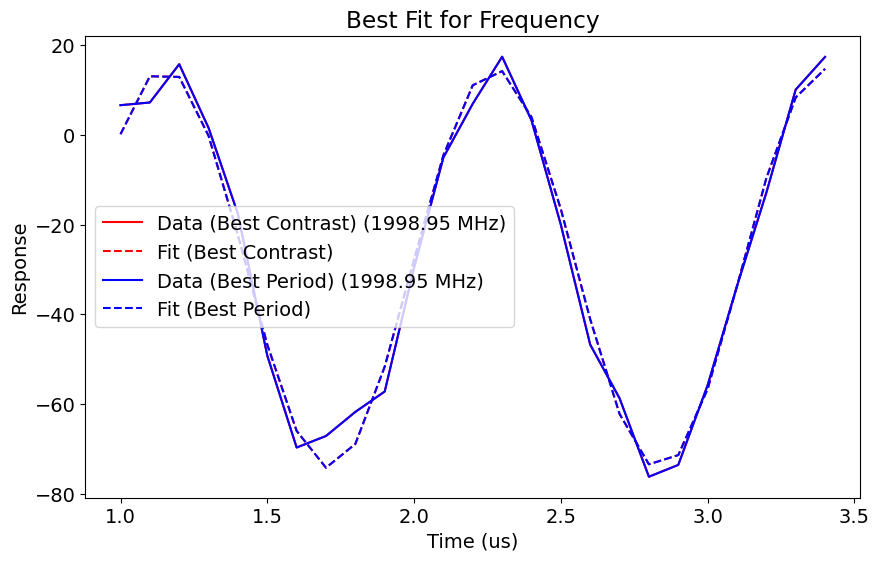

Saving D:\experiments\260112_qsim_calibration_practice\data\00007_LengthRabiGeneralF0g1Experiment_sweep.h5
Complete. Saved to D:\experiments\260112_qsim_calibration_practice\data\00007_LengthRabiGeneralF0g1Experiment_sweep.h5
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid


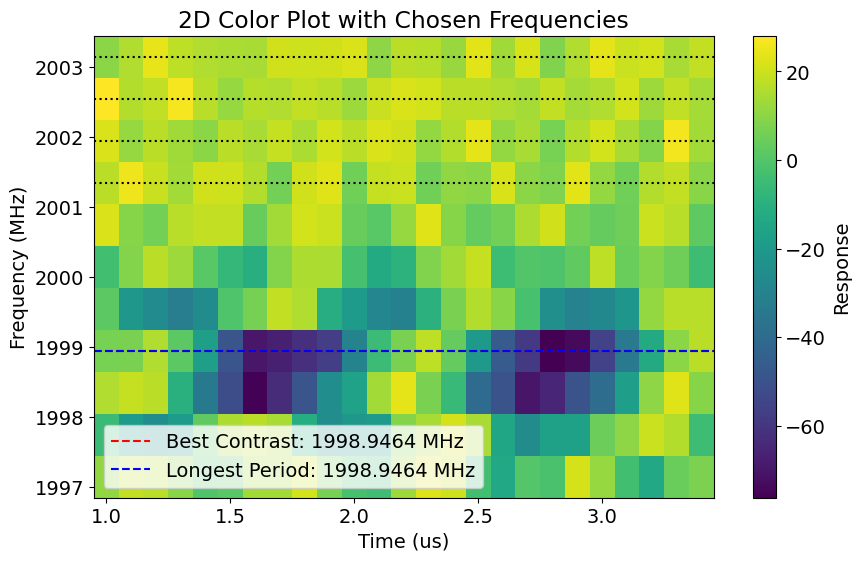

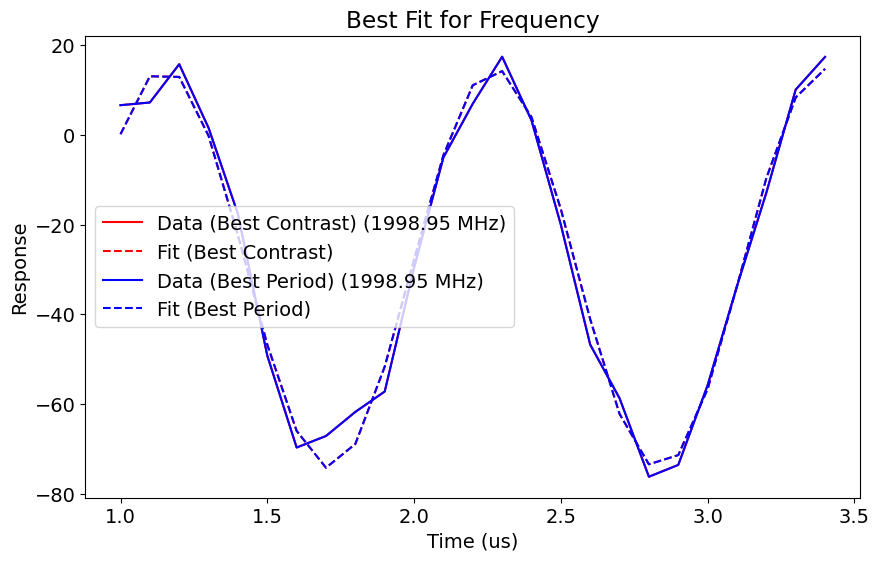

Best frequency found: 1998.9464 MHz
Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated M1 frequency to 1998.9464 MHz


In [ ]:
# coarse sweep
result = runner.execute(
    sweep_start=station.ds_storage.get_freq('M1') - 3,
    sweep_stop=station.ds_storage.get_freq('M1') + 3,
    sweep_npts=11,
    gain = station.ds_storage.get_gain('M1'),
    start = 1, # time start in us
)

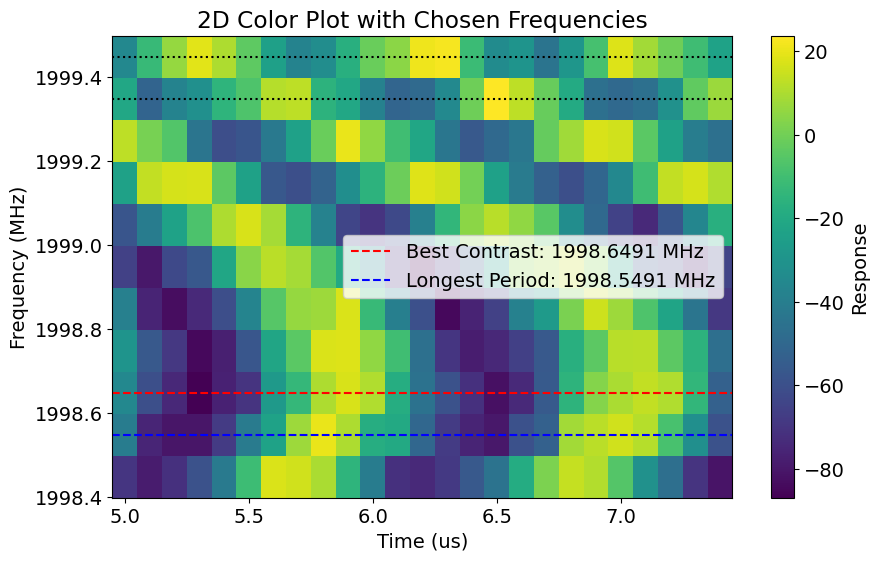

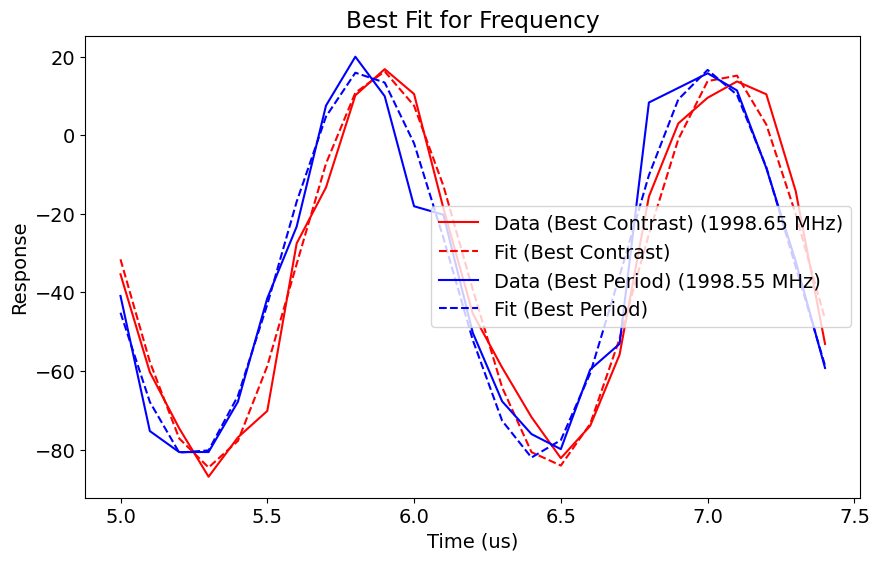

Saving D:\experiments\260112_qsim_calibration_practice\data\00006_LengthRabiGeneralF0g1Experiment_sweep.h5
Complete. Saved to D:\experiments\260112_qsim_calibration_practice\data\00006_LengthRabiGeneralF0g1Experiment_sweep.h5
uncertainty smells off, marking this line as invalid
uncertainty smells off, marking this line as invalid


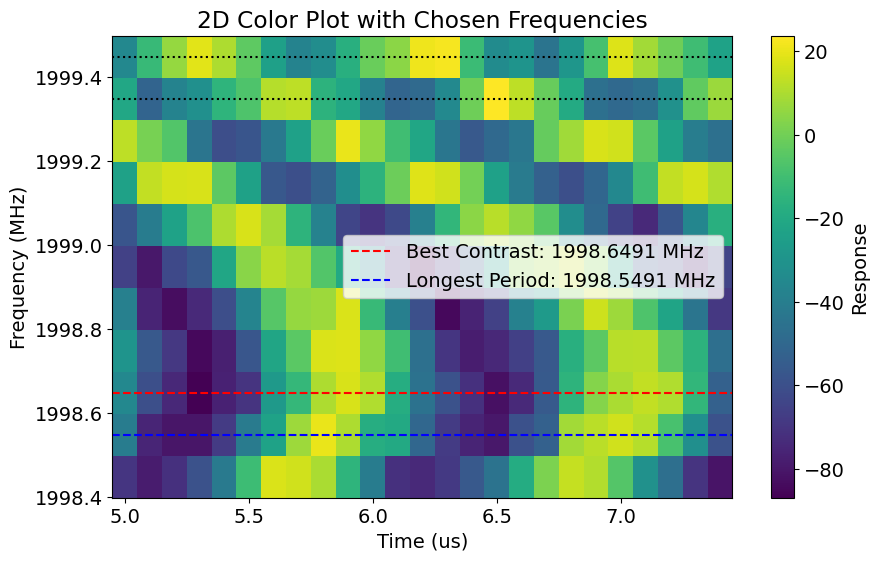

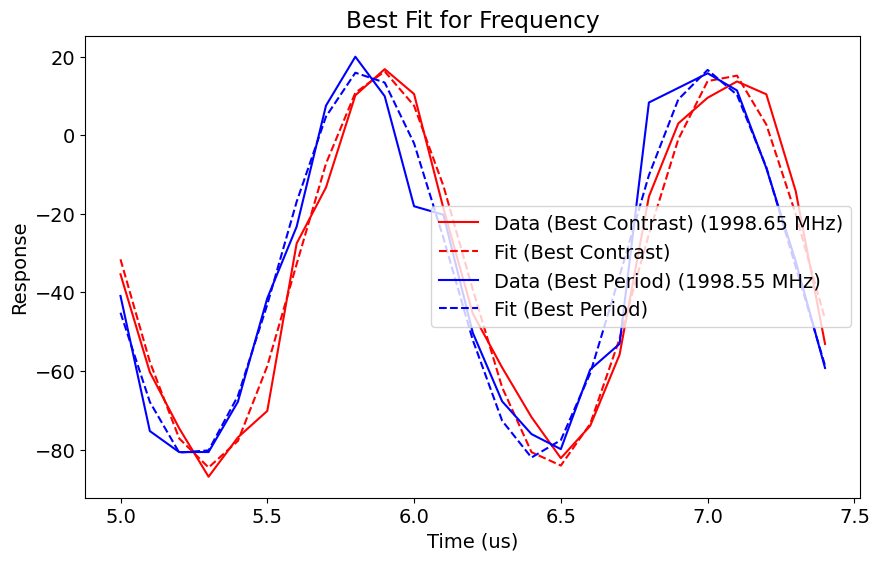

Best frequency found: 1998.6491 MHz
Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated M1 frequency to 1998.6491 MHz


In [ ]:
# fine sweep
result = runner.execute(
    sweep_start=station.ds_storage.get_freq('M1') - 0.5,
    sweep_stop=station.ds_storage.get_freq('M1') + 0.5,
    sweep_npts=11,
    gain = station.ds_storage.get_gain('M1'),
    start = 5, # time start in us
)

## Error amplification

cfg at start of acquire {'start': 1998, 'expts': 40, 'step': 0.025, 'reps': 1, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_pulses': 7, 'sideband': 'f0-g1', 'parameter_to_test': 'frequency', 'pulse_type': ['multiphoton', 'f0-g1', 'pi', 0], 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500}
n_pts [1 2 3 4 5 6 7]


  0%|          | 0/7 [00:00<?, ?it/s]

post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
post_pulse: [[3562.5885072817487, 3419.01692885307], [3319, 3074], [0, 0], [0, 0], [2, 2], ['gauss', 'gauss'], [0.035, 0.035]]
Saving D:\experiments\260112_qsim_calibration_practice\data\00009_ErrorAmplificationExperiment.h5
fitparams [-0

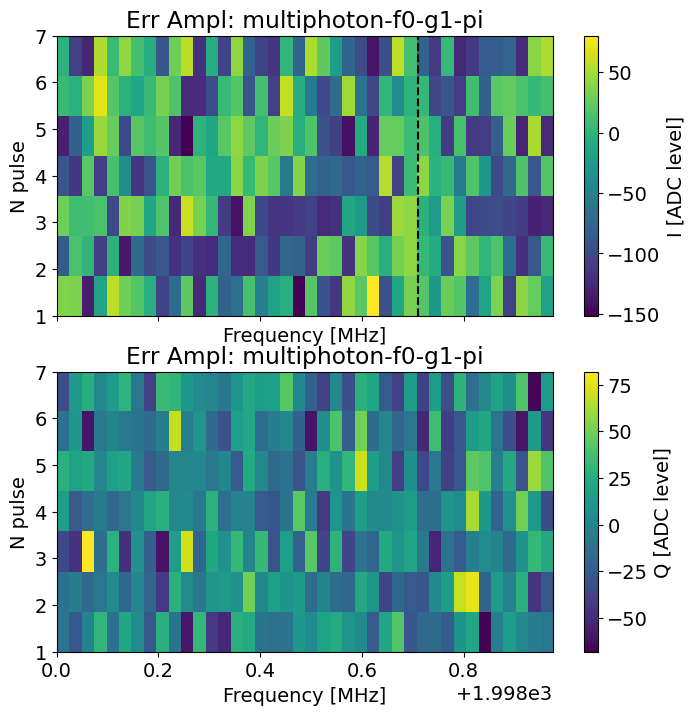

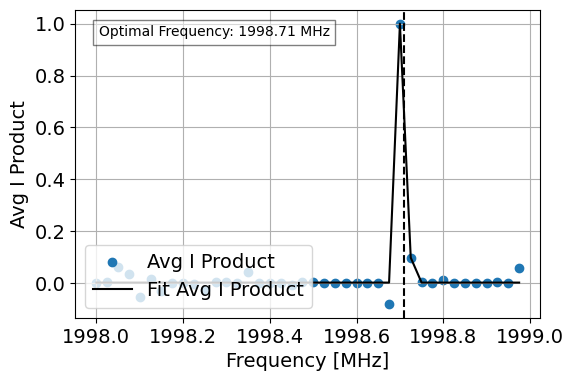

Error amplification analysis complete
Man f0-g1 pi frequency before update: 1998.6868657264545
Man f0-g1 pi frequency after update: 1998.709452801087
Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated the ds_storage frequency to: 1998.709452801087


In [ ]:
# Manipulate/Error Amplification - New Pattern with CharacterizationRunner

# Configuration defaults
error_amp_defaults = AttrDict(dict(
    start=1998,
    expts=40,
    step=0.025,
    reps=100,
    rounds=1,
    qubit=0,
    qubits=[0],
    n_pulses=7,
    sideband = 'f0-g1', #should be in the format of 'fn-gn+1' 
    parameter_to_test='frequency',
    pulse_type= None, # if this is None, will be set to ['multiphoton', sideband, 'pi', 0] in preproc
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
))

def error_amp_preproc(station, 
                      default_expt_cfg, 
                      **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    if expt_cfg.pulse_type is None:
        expt_cfg.pulse_type = ['multiphoton', expt_cfg.sideband, 'pi', 0]
    return expt_cfg

def error_amp_postproc(station, expt):
    """
    Postprocessor for error amplification.
    Analyze with custom parameters.
    """
    sideband = expt.cfg.expt.sideband
    _sideband = sideband[0] + 'n' + '-' + sideband[3] + 'n+1'
    i = int(sideband[1])
    # Perform analysis with state_fin='e' as in original code
    expt.analyze(data=expt.data, state_fin='e')
    # expt.display(data=expt.data, state_fin='e')
    print('Error amplification analysis complete')

    print(f"Man {sideband} pi frequency before update:", 
          station.hardware_cfg.device.multiphoton['pi'][_sideband]['frequency'][i])
    station.hardware_cfg.device.multiphoton['pi'][_sideband]['frequency'][i] = expt.data['fit_avgi'][2]
    print(f"Man {sideband} pi frequency after update:", 
          station.hardware_cfg.device.multiphoton['pi'][_sideband]['frequency'][i])
    if i > 0:
        print("WARNING! No update will occur! The update in this cell was meant for the csv which does not have multiphoton params. To update the multiphoton params, please run the multiphoton calibration notebook instead.")
    else:
        station.ds_storage.update_freq('M1', expt.data['fit_avgi'][2])
        print("Updated the ds_storage frequency to:", station.ds_storage.get_freq('M1'))

# Create runner
error_amp_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ErrorAmplificationExperiment,
    default_expt_cfg=error_amp_defaults,
    preprocessor=error_amp_preproc,
    postprocessor=error_amp_postproc,
    job_client=client,
)

# Example execution

# Run with analyze=False, display=False initially
# Postprocessor will handle custom analysis
error_amp_exp = error_amp_runner.execute(
    reps = 1,
    go_kwargs = dict(analyze=False, display=False),
    postprocess=True  # This will call postprocessor which does the custom analysis
)

error_amp_exp.display()

## Length Rabi f0g1 (Update time)

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
lenrabi_f0g1_defaults = AttrDict(dict(
    start=None,  # Will be computed in preprocessor (soc.cycles2us(3))
    step=0.01,
    qubits=[0],
    expts=150,
    reps=100,
    rounds=1,
    gain=8000,
    freq=None,  # Will be set from ds_storage in preprocessor
    use_arb_waveform=False,
    pi_ge_before=True,
    pi_ef_before=True,
    pi_ge_after=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    stor_reset=True,
    check_man_reset=[False, 0],
    swap_lossy=False,
    check_man_reset_pi=[],
    prepulse=False,
    pre_sweep_pulse=[],
    err_amp_reps=0,
    relax_delay=5000,
))

def lenrabi_f0g1_preproc(station, default_expt_cfg, man_mode_no=1, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.man_mode_no = man_mode_no  # Store for postprocessor
    expt_cfg.update(kwargs)
    
    # Compute start and freq from soc and ds_storage if not provided
    if expt_cfg.start is None:
        expt_cfg.start = station.soc.cycles2us(3)
    if expt_cfg.freq is None:
        expt_cfg.freq = station.ds_storage.get_freq('M' + str(man_mode_no))
    
    return expt_cfg

def lenrabi_f0g1_postproc(station, expt):
    man_mode_no = expt.cfg.expt.man_mode_no
    
    # Get analysis results from the LengthRabiFitting object stored in expt
    if hasattr(expt, '_length_rabi_analysis'):
        analysis = expt._length_rabi_analysis
        pi_length = analysis.results['pi_length']
        pi2_length = analysis.results['pi2_length']
        gain = expt.cfg.expt.gain
        freq = expt.cfg.expt.freq
        
        station.ds_storage.update_all('M' + str(man_mode_no), freq, None, pi_length, pi2_length, gain)
        print(f'Updated dataset M{man_mode_no}: pi_length={pi_length:.4f}, pi2_length={pi2_length:.4f}, gain={gain}')


Running length rabi for mode 1


  0%|          | 0/150 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 42.28187919463087, which is out of bounds 0.06756756756756757 to 33.78378378378378. Instead init to 16.925675675675674
Saving D:\experiments\260101_qsim\data\00006_LengthRabiGeneralF0g1Experiment.h5
p1: 0.8332776386989512
p2: 95.54100046380569
Pi length: 0.5815688667724646
Pi/2 length: 0.28154881536397997
p1: 14.485549800712121
p2: 50.76264056157366
Pi length: 0.04204139114393858
Pi/2 length: 0.02478281253011822


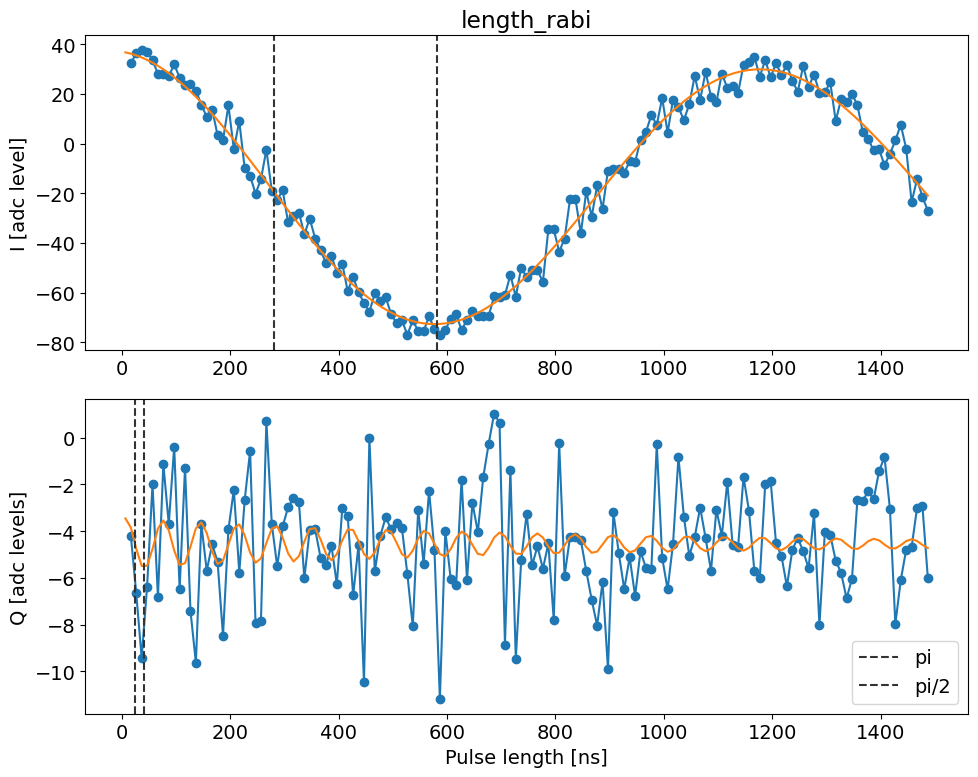

Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset_new.csv
Updated dataset M1: pi_length=0.5816, pi2_length=0.2815, gain=8000


In [ ]:
# Execute
# =================================
lenrabi_f0g1_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.LengthRabiGeneralF0g1Experiment,
    default_expt_cfg=lenrabi_f0g1_defaults,
    preprocessor=lenrabi_f0g1_preproc,
    postprocessor=lenrabi_f0g1_postproc,
    job_client=client,
)

len_rabis_mans = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print(f'Running length rabi for mode {i+1}')
        len_rabis_mans[i] = lenrabi_f0g1_runner.execute(
            man_mode_no=i+1,
            go_kwargs=dict(progress=True)
        )
        len_rabis_mans[i].display()


In [61]:
# len_rabis_mans[0].active_reset = True
# len_rabis_mans[0].analyze()
# len_rabis_mans[0].display(title_str='Length Rabi General F0g1')

## --- Manipulate sections below not refactored ---

## Chi between qubit and Manipulate 

### ge

In [85]:
mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
prep_man_pi = mm_base_dummy.prep_man_photon(1)
mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse

array([[3570.1569917242878, 3426.533540542471, 2006.6594442381024],
       [3523, 2909, 8000],
       [0, 0, 0.5884878240625507],
       [0, 0, 0],
       [2, 2, 0],
       ['gauss', 'gauss', 'flat_top'],
       [0.035, 0.035, 0.005]], dtype=object)

In [ ]:
from experiments.MM_dual_rail_base import MM_dual_rail_base
import numpy as np

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
# do_t2_ramsey_ge is already defined in previous cells and can be used directly

# Add active_reset, relax_delay, expts as arguments and pass them to do_t2_ramsey_ge
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1, active_reset=False, relax_delay=2500, expts=100):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(
            config_thisrun, expt_path, config_path,
            pre_sweep_pulse=None, post_sweep_pulse=None,
            step_size=0.1,
            active_reset=active_reset,
            relax_delay=relax_delay,
            expts=expts
        )
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(
        config_thisrun, expt_path, config_path,
        pre_sweep_pulse=prepulse, post_sweep_pulse=None,
        step_size=0.1,
        active_reset=active_reset,
        relax_delay=relax_delay,
        expts=expts
    )

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse


def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi_ge[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


fge is  3569.7141623787825
fef is  3426.6982208338936


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00004_RamseyExperiment.h5
fge is  3569.7141623787825
fef is  3426.6982208338936


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00005_RamseyExperiment.h5
No echoes in the data
Attempted to init fitparam 4 to -52.724925000000006, which is out of bounds -27.571309523809525 to 4.514718614718615. Instead init to -11.528295454545455
Current pi pulse frequency: 3569.7141623787825
Fit frequency from I [MHz]: 2.0 +/- inf
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.7141623787825
 	3574.7141623787825
T2 Ramsey from fit I [us]: 9.9
Fit frequency from Q [MHz]: 2.076533826954893 +/- 0.024749944810192936
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3570.6376285518277
 	3574.7906962057373
T2 Ramsey from fit Q [us]: 2.9700000000000006


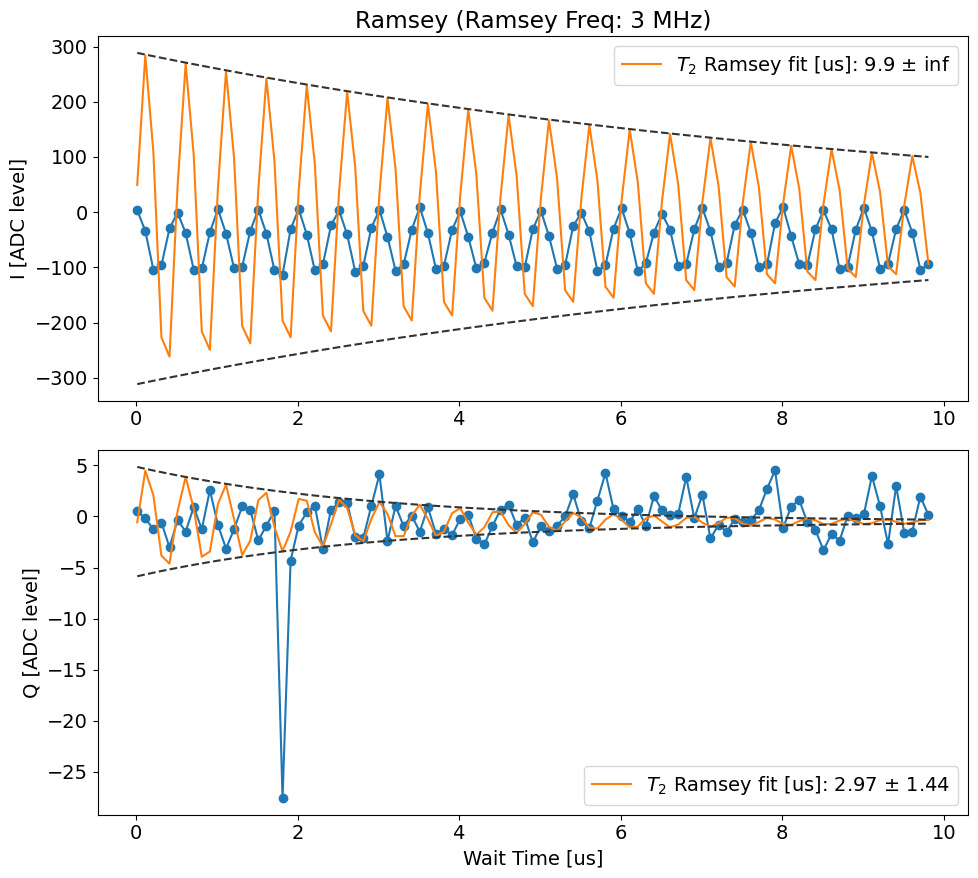

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_10-59-59_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
No echoes in the data
Attempted to init fitparam 4 to -51.17035303030303, which is out of bounds -3.31245670995671 to 8.356028138528139. Instead init to 2.5217857142857145
Current pi pulse frequency: 3569.7141623787825
Fit frequency from I [MHz]: 1.71978267183764 +/- 0.0012380111575450356
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.994379706945
 	3574.43394505062
T2 Ramsey from fit I [us]: 14.777506484792996
Fit frequency from Q [MHz]: 1.7361956078739427 +/- 0.01620406466299428
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3570.9779667709086
 	3574.4503579866564
T2 Ramsey from fit Q [us]: 2.9700000000000006


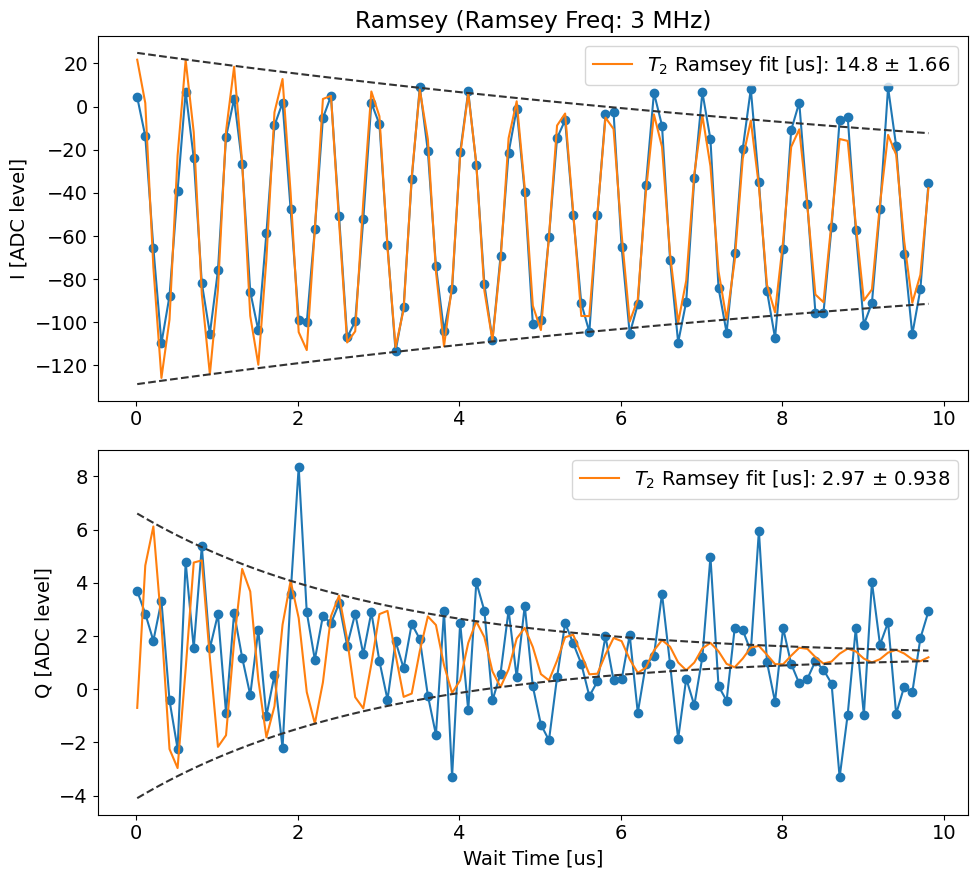

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-11-11_11-00-00_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-11-11.md
Chi: 0.2802173281623599
Delay time (mus): 1.7843293392273603
Only doing it for mode 1


In [87]:
t2_ramsey_original, t2_ramsey_prepulse = None, None
# Run the chi experiments/__pycache__/
if expts_to_run['chi_ge']:
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

In [ ]:
# config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

### ef

In [ ]:
from experiments.MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi_f(config_thisrun, expt_path, config_path, 
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """

    
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    # Add qubit ge prepulse and postpulse for ef (ge init)
    qubit_ge_prepulse = [['qubit', 'ge', 'pi', 0]]
    prep_man_pi_prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    prepulse =  mm_base_dummy.get_prepulse_creator(prep_man_pi + qubit_ge_prepulse ).pulse.tolist() 
    postpulse  = mm_base_dummy.get_prepulse_creator(qubit_ge_prepulse).pulse.tolist()

    # Add chi to frequency of qubit ge 
    # prepulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]
    # postpulse[0][-1] += config_thisrun.device.manipulate.chi[man_mode_no - 1]

    # Do an ef and ge ramsey with this prepulse 
    # Run ge Ramsey 
    
    
    t2ramsey_no_prepulse_ge = do_t2_ramsey_ge(config_thisrun,
        expt_path,
        config_path,
        step_size=0.1,
        pre_sweep_pulse=prep_man_pi_prepulse,
        post_sweep_pulse=None)
    # Run ef Ramsey with prepulse and postpulse
    t2ramsey_with_prepulse_ef = do_t2_ramsey_ef(
        config_thisrun,
        expt_path,
        config_path,
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
        step_size=0.1,
        ef_init=False  # Do not initialize ef, we are already in ef state
    )
    

    return t2ramsey_no_prepulse_ge, t2ramsey_with_prepulse_ef

def update_chi_ef(t2_standard_ramsey, t2_prepulsed_ramsey, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_with_prepulse = t2_prepulsed_ramsey.data['f_adjust_ramsey_avgi'][0]
    f_without_prepulse = t2_standard_ramsey.data['f_adjust_ramsey_avgi'][0]
    chi_ef = f_with_prepulse - f_without_prepulse
    print('Chi:', chi_ef)
    config_thisrun.device.manipulate.chi_ef[man_mode_no - 1] = chi_ef


In [ ]:
man_mode_no = 1
t2ge_ramsey_forchief, t2ef_ramsey_forchief = None, None
t2ef_standard_ramsey_forchief = None
if expts_to_run['chi_ef']:
    
    #get standard ef ramsey 
    t2ef_standard_ramsey_forchief = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    # analyze and display the results
    t2ef_standard_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_standard_ramsey_forchief.display(title_str='T2_ef_standard_for_chief')

    # Now ramseys with man photon prepulse
    config_thisrun_chief = deepcopy(config_thisrun)
    config_thisrun_chief.device.qubit.f_ge[0] += config_thisrun.device.manipulate.chi_ge[man_mode_no - 1]
    t2ge_ramsey_forchief, t2ef_ramsey_forchief = do_chi_f(config_thisrun_chief, expt_path, config_path)
    # analyze and display the results
    t2ge_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ge_ramsey_forchief.display(title_str='T2_ge_for_chief_tocheck_this_is_correctly_at_ramsey_freq')
    t2ef_ramsey_forchief.analyze(fitparams=[300, None, None, None, None, None])
    t2ef_ramsey_forchief.display(title_str='T2_ef_for_chief')
    # update the config_thisrun with the chi value
    update_chi_ef(t2ef_standard_ramsey_forchief, t2ef_ramsey_forchief, config_thisrun)


## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [ ]:
def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_storage.get_freq(f'M{man_mode_no}'), ds_storage.get_gain(f'M{man_mode_no}'), ds_storage.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



In [ ]:
t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2
06/19/2025: The code below should use man ramsey directly instead of user defined; user defined is for ramsey where you directly displace manipulate mode  - Eesh

In [ ]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.02*7.5,
        expts=600,
        # ramsey_freq=-3.5,
        ramsey_freq=1.5,
        reps=100,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[False, ds_storage.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_storage.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_storage.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_mode_no=man_mode_no ,
        storage_ramsey=[False, 2, True],
        man_ramsey=[True, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[True, 1],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

In [ ]:
cavity_ramsey.analyze(fitparams=[300, None, None, None, None, None])
cavity_ramsey.display()

# Storage

In [7]:
# Storage Spectroscopy - New Pattern with CharacterizationRunner
from experiments.MM_dual_rail_base import MM_dual_rail_base

In [8]:
# Helper function (kept from original)
def get_storage_mode_parameters(ds_storage, config_thisrun, man_mode_no, stor_mode_no):
    """Get pulse parameters for a given storage mode."""
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq < 1000 else flux_high_ch

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=station.soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse

## Man-Stor Spectroscopy

In [8]:
# Configuration defaults
stor_spec_defaults = AttrDict(dict(
    step=0.08,  # bw/expts = 20/250
    expts=250,
    reps=200,
    qubit=[0],
    flux_drive=[0, 1, 3000, 5],  # [ch, freq_placeholder, gain, length(us)]
    prepulse=True,
    postpulse=True,
    active_reset=True,
    relax_delay=500,
))

def stor_spec_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, bw=20, **kwargs):
    """Preprocessor for storage spectroscopy."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    # Get storage mode parameters
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )
    
    # Set sweep range centered on current frequency
    expt_cfg.start = freq - bw/2
    expt_cfg.step = bw / expt_cfg.expts
    
    # Set flux drive channel and prepulse/postpulse
    expt_cfg.flux_drive = [ch, 1, 3000, 5]
    expt_cfg.pre_sweep_pulse = prepulse
    expt_cfg.post_sweep_pulse = postpulse
    
    print(f'Storage spectroscopy for M{man_mode_no}-S{stor_mode_no}: freq={freq:.3f} MHz, bw={bw} MHz')
    
    return expt_cfg

def stor_spec_postproc(station, expt, man_mode_no=1, stor_mode_no=1):
    """Postprocessor for storage spectroscopy - updates frequency."""
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    new_freq = expt.data['fit_avgi'][2]
    station.ds_storage.update_freq(stor_name, new_freq)
    print(f'Updated frequency for {stor_name}: {new_freq:.4f} MHz')

# Create runner
stor_spec_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.FluxSpectroscopyF0g1Experiment,
    default_expt_cfg=stor_spec_defaults,
    preprocessor=stor_spec_preproc,
    postprocessor=stor_spec_postproc,
    job_client=client,
)

# Execute for all storage modes
if expts_to_run.get('stor_spectroscopy', False):
    stor_specs = {}
    # for stor_mode_no in range(1, 8):  # modes 1-7
    for stor_mode_no in [5]:  # modes 1-7
        print(f'Running storage spectroscopy for mode {stor_mode_no}')
        stor_specs[stor_mode_no] = stor_spec_runner.execute(
            man_mode_no=1,
            stor_mode_no=stor_mode_no,
        )
        stor_specs[stor_mode_no].display()

Running storage spectroscopy for mode 5
Storage spectroscopy for M1-S5: freq=1057.076 MHz, bw=20 MHz
Job submitted: JOB-20260122-00087 (queue position: 1)

[0.1s] Job JOB-20260122-00087: pending


: 

### Save dataset and update to main if desired

In [ ]:
station.snapshot_man1_storage_swap(update_main=False)
# station.snapshot_man1_storage_swap(update_main=True)

## Man-dump (to be updated)

In [ ]:
from experiments.MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
prep_man_pi = mm_base_dummy.prep_man_photon(1)
prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

In [ ]:
def get_dump_mode_parameters(ds_storage, config_thisrun, man_mode_no, dump_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_storage: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-D' + str(dump_mode_no)
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    from experiments.MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    prepulse_overwrite = [['multiphoton', 'g0-e0', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0],
                            ['multiphoton', 'f0-g1', 'pi', 0]
                        ]
    postpulse_overwrite = [ ['multiphoton', 'f0-g1', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0]]
    prepulse = mm_base_dummy.get_prepulse_creator(prepulse_overwrite).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(postpulse_overwrite).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_dump_spectroscopy(config_thisrun, 
                         ds_storage, 
                         expt_path, 
                         config_path, 
                         man_mode_no = 1, 
                         dump_no = 1,
                         flux_gain = 5000,
                         flux_length = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_storage (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_dump_mode_parameters(ds_storage, config_thisrun,
                                                                      man_mode_no, dump_no)

    freq_start = 2300 #2350 
    freq_stop = 2400 #2400
    bw = freq_stop - freq_start
    expts = 200
    step = bw/expts



    flux_spec.cfg.expt = dict(
        # start=freq - 100,  # Start RF frequency [MHz]
        start=freq_start,  # Start RF frequency [MHz]
        step=step,  # Step size [MHz]
        expts=expts,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1, flux_gain, flux_length],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=False,
        storage_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_storage, man_mode_no = 1, dump_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_storage.update_freq('M' + str(man_mode_no) + '-D' + str(dump_no), flux_spec.data['fit'][2])
    print(f"Updated frequency for M{man_mode_no}-D{dump_no}: {flux_spec.data['fit'][2]}")


  0%|          | 0/200 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00066_FluxSpectroscopyF0g1Experiment.h5
[2349.75, 5000, 1000, 0, 18.761375150834397, 45.6331330951766, 0.02143676200789486]
[ 2.33984864e+03  7.35801659e+01  4.02726895e+03  4.16975922e+00
  2.74527879e+02  3.96070282e+01 -1.97332185e-02]

Freq with minimum transmission: 2307.0
Freq with maximum transmission: 2317.5
From fit:
	f0: 2339.8486419035144
	Qi: 73.5801659495338
	Qe: 4027.268945579364
	Q0: 72.25994160722864
	kappa [MHz]: 32.38099270300883
	phi [radians]: 4.169759216586551


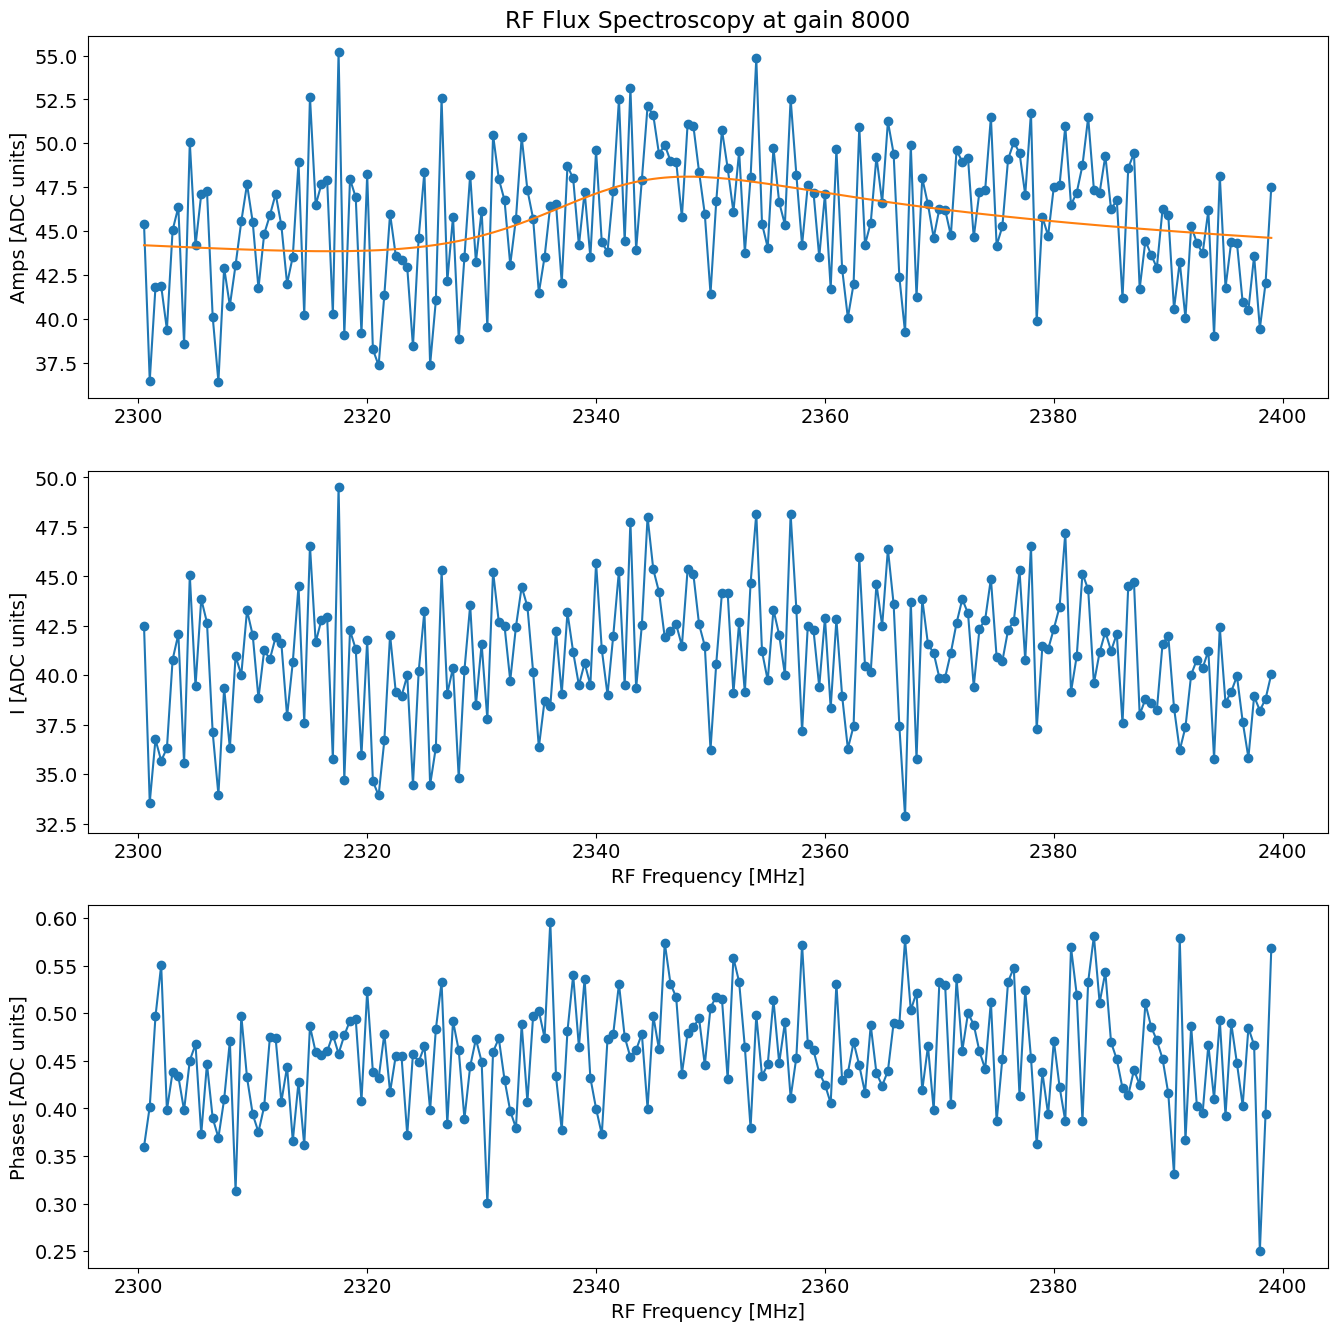

In [ ]:
spec = do_dump_spectroscopy(config_thisrun, ds_storage, expt_path, config_path, 
                            man_mode_no=1, dump_no=1,
                            flux_gain=8000, flux_length=5)
# analyze_and_display_stor_spectroscopy(spec)
# update_dump_spectroscopy(spec, ds_storage, 1, 1)
spec.analyze(fit=True)
spec.display()

[800, 100, 40, 0, 60, 0, 0]
Attempted to init fitparam 0 to 800, which is out of bounds 2300.5 to 2399.0. Instead init to 2349.75
Attempted to init fitparam 5 to 0, which is out of bounds 36.43136144142213 to 55.19273659225653. Instead init to 45.81204901683933
[ 2.34935972e+03  4.95647667e+01 -1.43279492e-02 -1.96878130e-02
  3.59701734e+01  4.49077442e+01  1.75028352e-02]

Freq with minimum transmission: 2307.0
Freq with maximum transmission: 2317.5
From fit:
	f0: 2349.359724743213
	Qi: 49.564766692222385
	Qe: -0.014327949169025706
	Q0: -0.014332092222701877
	kappa [MHz]: -163923.01195368063
	phi [radians]: -0.01968781304613659


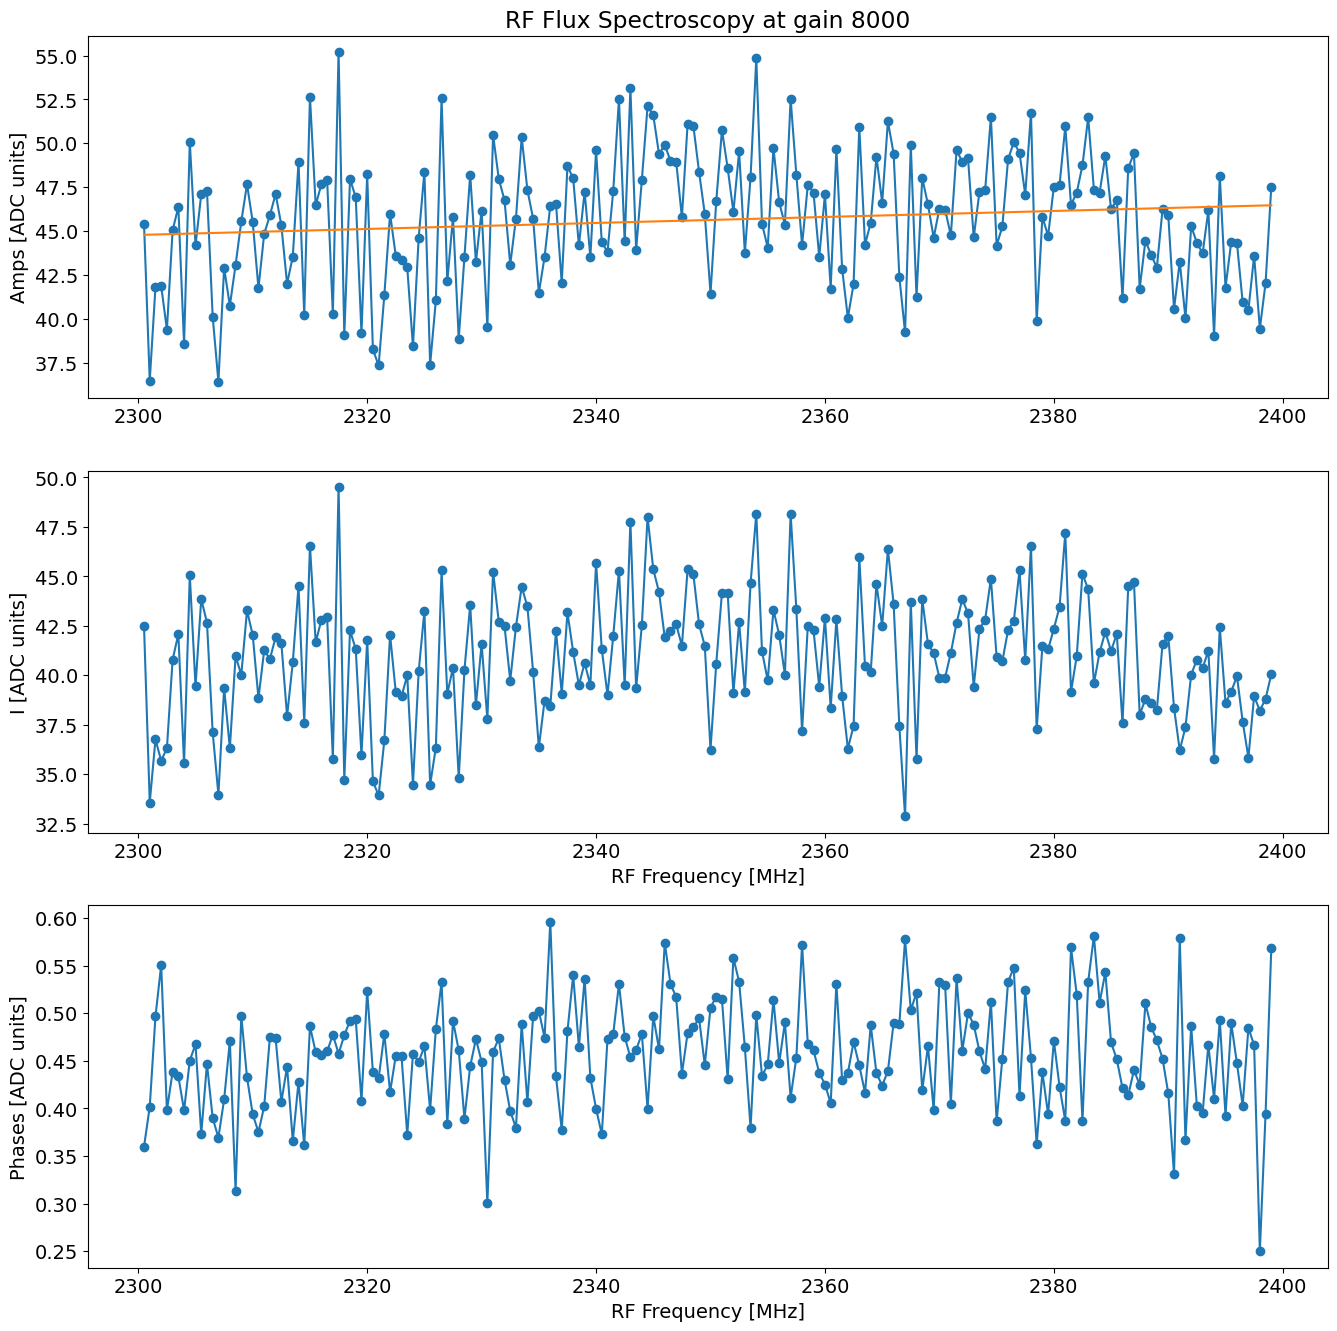

In [76]:
spec.analyze(fit=True, fitparams=[800, 100, 40, 0, 60, 0, 0])
spec.display()

In [ ]:
ds_storage.update_freq('M1-C', 781.5)


Creating or updating new csv at path: man1_storage_swap_dataset_copy.csv


In [ ]:
res = []

gains = np.arange(500, 2001, 50)
for flux_gain in tqdm(gains):
    spec = do_dump_spectroscopy(config_thisrun, ds_storage, expt_path, config_path, 
                                man_mode_no=1, dump_no=1,
                                flux_gain=flux_gain, flux_length=1)
    res.append(spec.data['avgi'])
res = np.array(res)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 1/31 [02:13<1:06:51, 133.73s/it]

Saving D:\experiments\251111_qec\data\00067_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▋         | 2/31 [04:27<1:04:31, 133.49s/it]

Saving D:\experiments\251111_qec\data\00068_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 10%|▉         | 3/31 [06:40<1:02:21, 133.62s/it]

Saving D:\experiments\251111_qec\data\00069_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 13%|█▎        | 4/31 [08:54<1:00:04, 133.52s/it]

Saving D:\experiments\251111_qec\data\00070_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 16%|█▌        | 5/31 [11:07<57:50, 133.49s/it]  

Saving D:\experiments\251111_qec\data\00071_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 19%|█▉        | 6/31 [13:21<55:38, 133.56s/it]

Saving D:\experiments\251111_qec\data\00072_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 23%|██▎       | 7/31 [15:34<53:25, 133.57s/it]

Saving D:\experiments\251111_qec\data\00073_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 26%|██▌       | 8/31 [17:48<51:11, 133.53s/it]

Saving D:\experiments\251111_qec\data\00074_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 29%|██▉       | 9/31 [20:02<48:58, 133.59s/it]

Saving D:\experiments\251111_qec\data\00075_FluxSpectroscopyF0g1Experiment.h5


  0%|          | 0/200 [00:00<?, ?it/s]

 29%|██▉       | 9/31 [20:32<50:13, 136.96s/it]


KeyboardInterrupt: 

In [79]:
means = res.mean(axis=1)
stds = res.std(axis=1)
plt.errorbar(gains, means, yerr=stds, marker='o')

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
# ds_storage.update_freq('M1-D1',  2373.6)

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_storage.get_freq('M1-S' + str(i+1)))


Frequency for M1-S1: 352.8646394397659
Frequency for M1-S2: 524.7320407642399
Frequency for M1-S3: 700.8686805710045
Frequency for M1-S4: 880.813564008455
Frequency for M1-S5: 1057.186387129217
Frequency for M1-S6: 1248.764436536901
Frequency for M1-S7: 1427.0597036250686


## Man-coupler (to be updated)

In [ ]:
def get_coupler_parameters(ds_storage, config_thisrun, man_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_storage: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        dump_mode_no: Dump mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    stor_name = 'M' + str(man_mode_no) + '-C'
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    ch = 'low' if freq < 1000 else 'high'

    from experiments.MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    prepulse_overwrite = [['multiphoton', 'g0-e0', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0],
                            ['multiphoton', 'f0-g1', 'pi', 0]
                        ]
    postpulse_overwrite = [ ['multiphoton', 'f0-g1', 'pi', 0],
                            ['multiphoton', 'e0-f0', 'pi', 0]]
    prepulse = mm_base_dummy.get_prepulse_creator(prepulse_overwrite).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(postpulse_overwrite).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


def do_coupler_spectroscopy(config_thisrun, 
                         ds_storage, 
                         expt_path, 
                         config_path, 
                         man_mode_no = 1, 
                         dump_no = 1,
                         flux_gain = 5000,
                         flux_length = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_storage (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        dump_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_coupler_parameters(ds_storage, config_thisrun,
                                                                      man_mode_no)

    # freq = 420

    flux_spec.cfg.expt = dict(
        start=freq - 50,  # Start RF frequency [MHz]
        step=1,  # Step size [MHz]
        expts=100,  # Number of experiments
        reps=200,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1, flux_gain, flux_length],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=False,
        storage_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec


def update_dump_spectroscopy(flux_spec, ds_storage, man_mode_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_storage.update_freq('M' + str(man_mode_no) + '-C', flux_spec.data['fit'][2])
    print(f"Updated frequency for M{man_mode_no}-C: {flux_spec.data['fit'][2]}")

ds_storage.update_freq('M' + str(1) + '-C', 919)

NameError: name 'ds_storage' is not defined

  0%|          | 0/100 [00:00<?, ?it/s]

Saving D:\experiments\251111_qec\data\00042_FluxSpectroscopyF0g1Experiment.h5
[918.5, 5000, 1000, 0, 19.25501074376434, 10.189293553092234, -0.09560477328844824]
[ 9.39088029e+02  5.08955404e+05  1.63168812e+01 -5.17869390e+00
  1.36878971e+01 -2.76643858e+00  1.21313156e-01]

Freq with minimum transmission: 967.0
Freq with maximum transmission: 923.0
From fit:
	f0: 939.0880293149387
	Qi: 508955.4038289838
	Qe: 16.31688124471405
	Q0: 16.31635814961324
	kappa [MHz]: 57.5550022072296
	phi [radians]: -5.1786939027006005


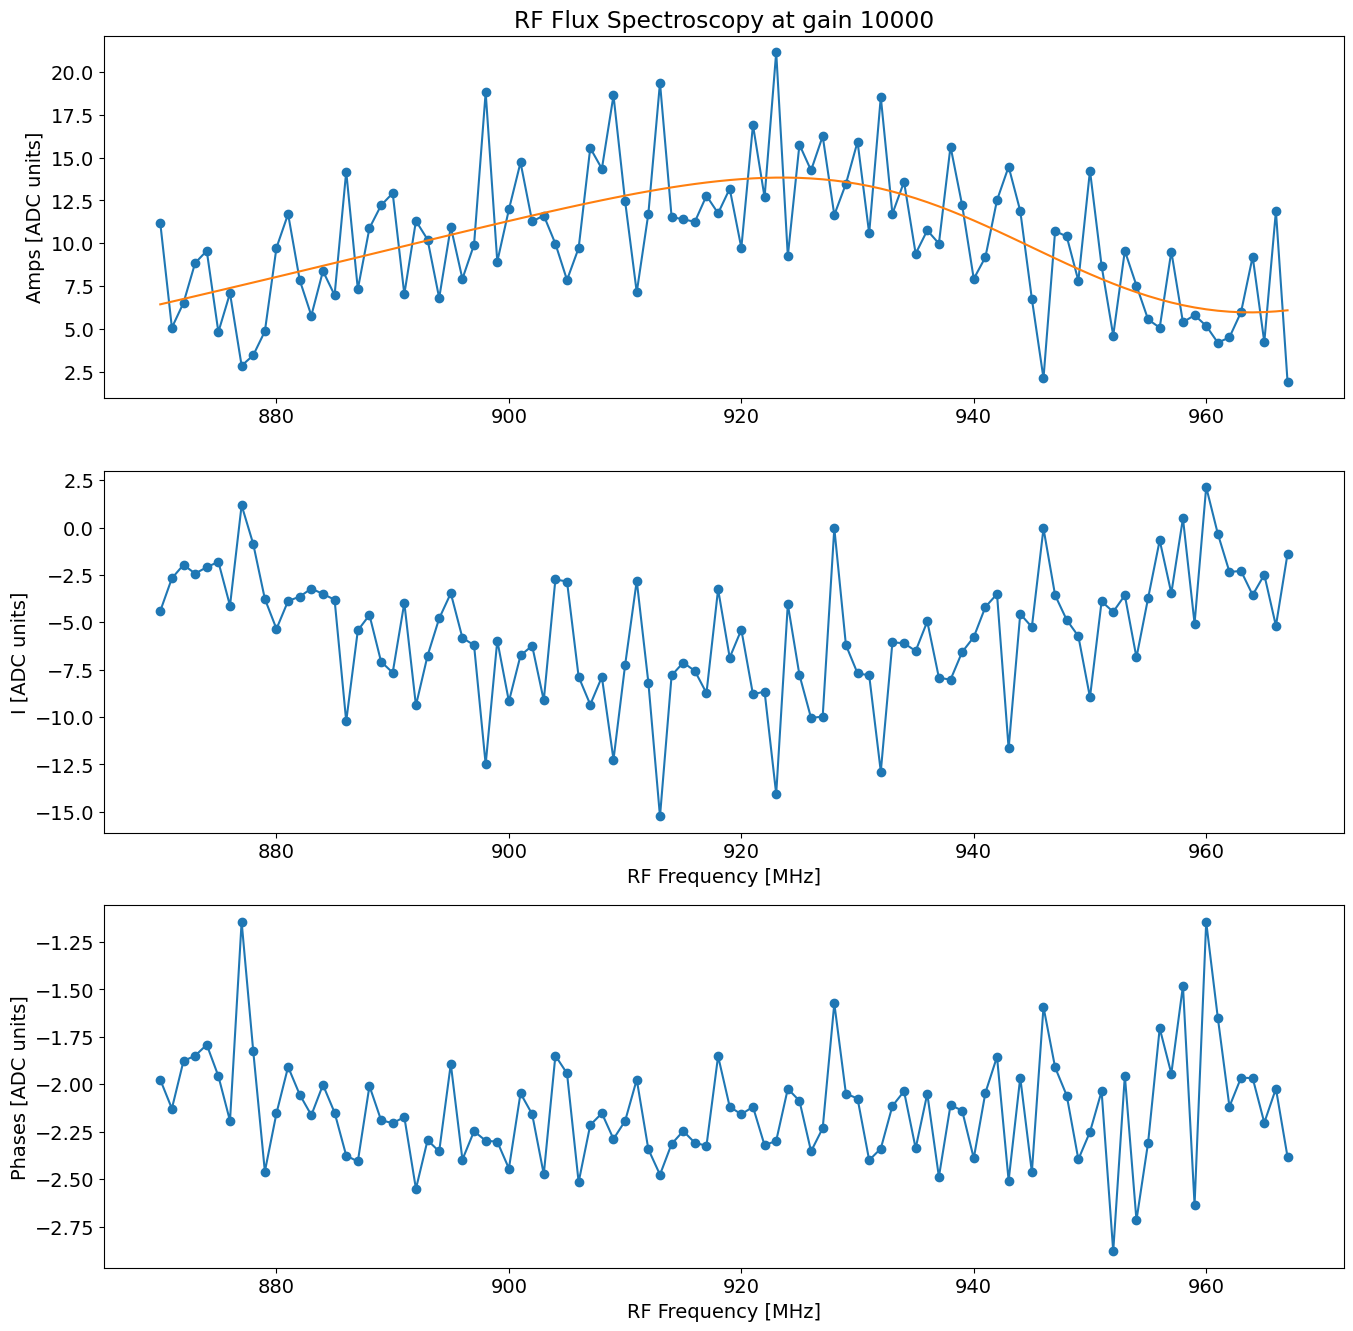

In [ ]:
spec = do_coupler_spectroscopy(config_thisrun, ds_storage, expt_path, config_path, man_mode_no=1,
                            flux_gain=10000, flux_length=2)
# analyze_and_display_stor_spectroscopy(spec)
# update_dump_spectroscopy(spec, ds_storage, 1, 1)
spec.analyze(fit=True)
spec.display()

## Find Freq Chevron + Error Amp

Freq chevron functions

In [ ]:
# Sideband Chevron - New Pattern with SweepRunner
from fitting.fit_display_classes import ChevronFitting
from datetime import datetime

# Configuration defaults for sideband sweep
sideband_chevron_defaults = AttrDict(dict(
    qubits=[0],
    start_time=0.007,
    expts=30,
    reps=50,
    rounds=1,
    freq_span=0.6,
    freq_step=0.1,
    prepulse=True,
    postpulse=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    update_post_pulse_phase=[False, 0],
    relax_delay=8000,
))

def sideband_chevron_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, **kwargs):
    """Preprocessor for sideband chevron sweep."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    stor_mode_no = expt_cfg.stor_mode_no    
    man_mode_no = expt_cfg.man_mode_no
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
        )
    
    pi_len_sweep = 2.0  # Fixed sweep length
    expt_cfg.step = pi_len_sweep / 10

    expt_cfg.freq_start = station.ds_storage.get_freq(stor_name) - expt_cfg.freq_span / 2
    expt_cfg.freq_stop = station.ds_storage.get_freq(stor_name) + expt_cfg.freq_span / 2
    
    # Set flux drive parameters
    expt_cfg.flux_drive = [ch, freq, gain, 0.05]
    expt_cfg.pre_sweep_pulse = prepulse
    expt_cfg.post_sweep_pulse = postpulse
    
    print(f'Sideband chevron for {stor_name}: freq={freq:.3f} MHz, gain={gain}')
    
    return expt_cfg

def sideband_chevron_postproc(station, mother_expt):
    """Postprocessor for sideband chevron - updates freq, pi_len, h_pi_len."""
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'

    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi'],
        config = config_thisrun,
        station=station,
    )
    
    # # Display results
    # current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # analysis.display_results(save_fig=True, title=f'{stor_name}_{current_time}')
    
    # Update frequency
    best_freq = analysis.results['best_frequency_period']
    station.ds_storage.update_freq(stor_name, best_freq)
    print(f'Updated frequency for {stor_name}: {best_freq:.4f} MHz')
    
    # Update pi_len and h_pi_len from fit
    pi_len = abs(np.pi / analysis.results['best_fit_params_period']['omega'])
    station.ds_storage.update_pi(stor_name, pi_len)
    station.ds_storage.update_h_pi(stor_name, pi_len / 2)
    print(f'Updated pi_len for {stor_name}: {pi_len:.4f} us')

# Create runners for each storage mode
sideband_chevron_runners = {}
for stor_mode_no in range(1, 8):  # modes 1-7
    sideband_chevron_runners[stor_mode_no] = SweepRunner(
        station=station,
        ExptClass=meas.single_qubit.sideband_general.SidebandGeneralExperiment,
        AnalysisClass=ChevronFitting,
        default_expt_cfg=sideband_chevron_defaults,
        sweep_param='freq',
        preprocessor=lambda s, cfg, m=1, st=stor_mode_no, **kw: sideband_chevron_preproc(s, cfg, man_mode_no=m, stor_mode_no=st, **kw),
        postprocessor=lambda s, a, m=1, st=stor_mode_no: sideband_chevron_postproc(s, a, man_mode_no=m, stor_mode_no=st),
    )

# Example execution for storage mode 1
if expts_to_run.get('sideband_freq_sweep', False):
    for stor_mode_no in expts_to_run.get('stor_modes', [1]):
        stor_name = f'M1-S{stor_mode_no}'
        freq_center = station.ds_storage.get_freq(stor_name)
        
        print(f'Running sideband chevron for {stor_name}')
        chevron_analysis = sideband_chevron_runners[stor_mode_no].execute(
            sweep_start=freq_center - 0.3,
            sweep_stop=freq_center + 0.3,
            sweep_step=0.1,
            go_kwargs=dict(progress=True),
            man_mode_no=1,
            stor_mode_no=stor_mode_no,
        )
        

TypeError: SweepRunner.__init__() got an unexpected keyword argument 'AnalysisClass'

Error amplification functions

In [ ]:
error_amp_stor_defaults = AttrDict(dict(
    reps=50,
    rounds=1,
    qubits=[0],
    active_reset=False,
    man_mode_no=1,
    stor_is_dump=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500, 
    expts=30,
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

error_amp_gain_stor_coarse_defaults = AttrDict(dict(
    n_start=0,
    n_step=3,
    n_pulses=15,
    expts=50,
))

error_amp_freq_stor_coarse_defaults = AttrDict(dict(
    n_start=0,
    n_step=2,
    n_pulses=10,
    expts=50,
))


def error_amp_stor_preproc(station, default_expt_cfg, **kwargs):
    assert 'stor_mode_no' in kwargs
    assert 'parameter_to_test' in kwargs 

    # construct the defaults
    expt_cfg = deepcopy(default_expt_cfg)
    if kwargs['parameter_to_test'] == 'gain':
        expt_cfg.update(error_amp_gain_stor_coarse_defaults)
    elif kwargs['parameter_to_test'] == 'frequency':
        expt_cfg.update(error_amp_freq_stor_coarse_defaults)

    # override with the passed kwargs
    expt_cfg.update(kwargs)

    stor_mode_no = expt_cfg.stor_mode_no    
    man_mode_no = expt_cfg.man_mode_no

    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
        )

    if 'span' not in expt_cfg:
        if expt_cfg.parameter_to_test == 'gain':
            expt_cfg.span = int(gain * 0.3)
        elif expt_cfg.parameter_to_test == 'frequency':
            expt_cfg.span = 0.15
  
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    pulse_type = ['storage', stor_name, 'pi', 0]

    if expt_cfg.parameter_to_test == 'frequency':
        start = freq - expt_cfg.span / 2
        step = expt_cfg.span / (expt_cfg.expts - 1)
    elif expt_cfg.parameter_to_test == 'gain':
        start = int(gain - expt_cfg.span / 2)
        step = int(expt_cfg.span / (expt_cfg.expts - 1))
    else:
        raise ValueError("parameter_to_test must be either 'frequency' or 'gain'.")
    expt_cfg.start = start
    expt_cfg.step = step
    expt_cfg.pulse_type = pulse_type 
    return expt_cfg

def error_amp_stor_postproc(station, expt):
    expt.analyze(data=expt.data, state_fin='e')
    expt.display()

    opt_gain = expt.data['fit_avgi'][2]
    stor_name = 'M1-S' + str(expt.cfg.expt.stor_mode_no)
    if expt.cfg.expt.parameter_to_test == 'gain':
        station.ds_storage.update_gain(stor_name, opt_gain)
    elif expt.cfg.expt.parameter_to_test == 'frequency':
        station.ds_storage.update_freq(stor_name, opt_gain)


error_amp_stor_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ErrorAmplificationExperiment,
    default_expt_cfg=error_amp_stor_defaults,
    preprocessor=error_amp_stor_preproc,
    postprocessor=error_amp_stor_postproc,
    job_client=client,
)

### Run

In [ ]:
stor_modes_to_run = list(range(2, 8)) #list(range(1,8))
error_amp_gain1 = [None] * len(stor_modes_to_run)
error_amp_freq1 = [None] * len(stor_modes_to_run)
error_amp_gain2 = [None] * len(stor_modes_to_run)
error_amp_freq2 = [None] * len(stor_modes_to_run)

Running M1-S2
Job submitted: JOB-20260122-00110 (queue position: 1)

[0.1s] Job JOB-20260122-00110: pending

[2.1s] Job JOB-20260122-00110: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00110_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubits': [0], 'active_reset': False, 'man_mode_no': 1, 'stor_is_dump': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'expts': 50, 'n_start': 0, 'n_step': 3, 'n_pulses': 15, 'stor_mode_no': 2, 'parameter_to_test': 'gain', 'go_kwargs': {'analyze': False, 'progress': True, 'display': False}, 'span': 1620, 'start': 4592, 'step': 33, 'pulse_type': ['storage', 'M1-S2', 'pi', 0]}
n_pts [ 0  3  6  9 12 15]
  0%|                                                    | 0/6 [00:00<?, ?it/s]qubit_start_storage: g
prepulse list: [['qubit', 'ge', 'pi

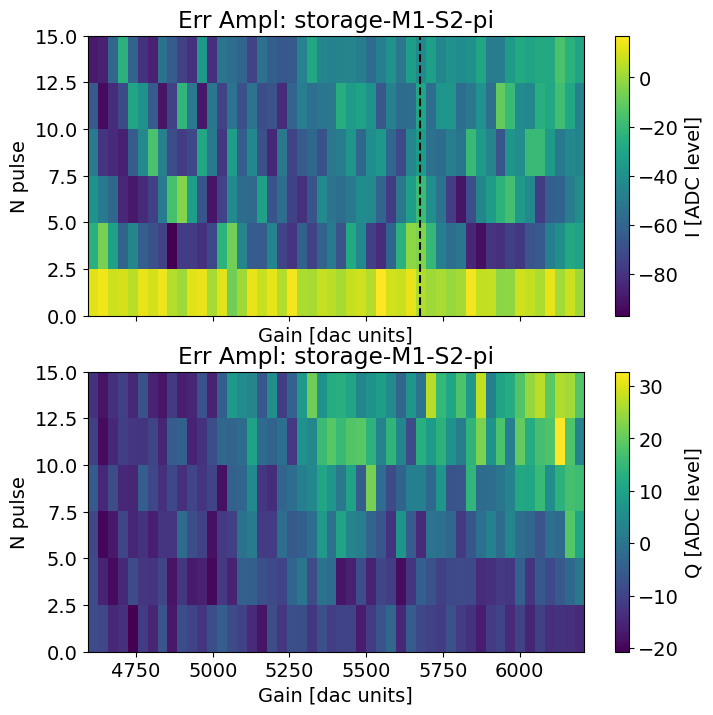

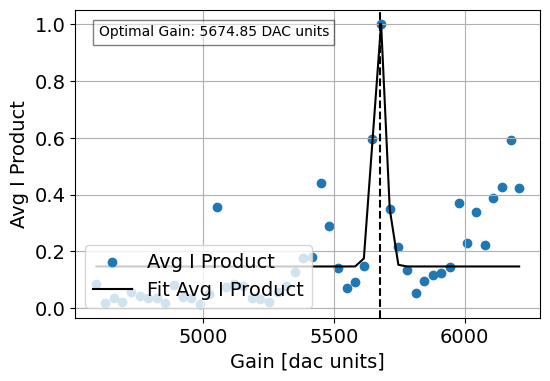

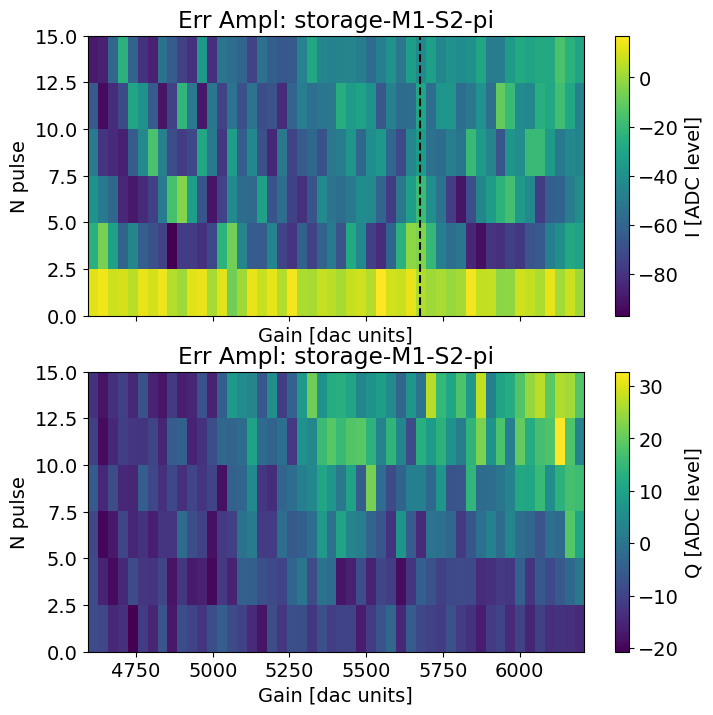

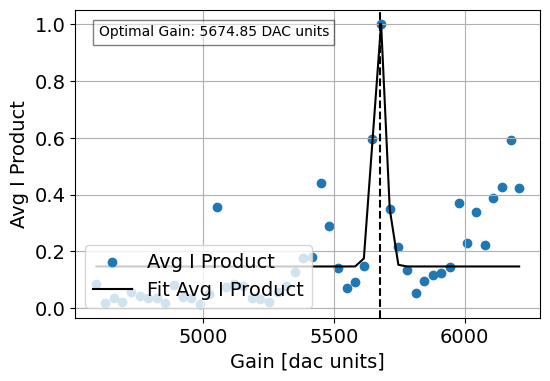

Job submitted: JOB-20260122-00111 (queue position: 1)

[0.1s] Job JOB-20260122-00111: pending

[2.1s] Job JOB-20260122-00111: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00111_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubits': [0], 'active_reset': False, 'man_mode_no': 1, 'stor_is_dump': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'expts': 50, 'n_start': 0, 'n_step': 2, 'n_pulses': 10, 'stor_mode_no': 2, 'parameter_to_test': 'frequency', 'go_kwargs': {'analyze': False, 'progress': True, 'display': False}, 'span': 0.15, 'start': 524.603959916449, 'step': 0.003061224489795918, 'pulse_type': ['storage', 'M1-S2', 'pi', 0]}
n_pts [ 0  2  4  6  8 10]
  0%|                                                    | 0/6 [00:00<?, ?it/s]qubit_start_storage: g
prepulse list:

: 

In [20]:
for i, stor_i in enumerate(stor_modes_to_run):
    stor_name = 'M1-S' + str(stor_i)
    print("Running", stor_name)
    error_amp_gain1[i] = error_amp_stor_runner.execute(
        stor_mode_no=stor_i,
        parameter_to_test='gain',
        go_kwargs=dict(analyze=False, progress=True, display=False),
    )
    error_amp_gain1[i].display()

    error_amp_freq1[i] = error_amp_stor_runner.execute(
        stor_mode_no=stor_i,
        parameter_to_test='frequency',
        go_kwargs=dict(analyze=False, progress=True, display=False),
    )
    error_amp_freq1[i].display()

In [10]:
station.snapshot_man1_storage_swap(update_main=True)

[CONFIG] Reusing existing man1_storage_swap version CFG-M1-20260122-00013
[CONFIG] Updated main man1_storage_swap to CFG-M1-20260122-00013


'CFG-M1-20260122-00013'

### Sideband Chevron - New Pattern (Template)

In [ ]:
# Sideband Chevron - New Pattern with SweepRunner
from fitting.fit_display_classes import ChevronFitting
from datetime import datetime

# Configuration defaults for sideband sweep
sideband_chevron_defaults = AttrDict(dict(
    reps=50,
    rounds=1,
    qubit=0,
    qubits=[0],

    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
))

def sideband_chevron_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, **kwargs):
    """Preprocessor for sideband chevron sweep."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    # Get storage mode parameters
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )
    
    # Set step size based on pi_len
    pi_len_sweep = 2.0  # Fixed sweep length
    expt_cfg.step = pi_len_sweep / 10
    
    # Set flux drive parameters
    expt_cfg.flux_drive = [ch, freq, gain, 0.05]
    expt_cfg.pre_sweep_pulse = prepulse
    expt_cfg.post_sweep_pulse = postpulse
    
    print(f'Sideband chevron for M{man_mode_no}-S{stor_mode_no}: freq={freq:.3f} MHz, gain={gain}')
    
    return expt_cfg

def sideband_chevron_postproc(station, analysis, man_mode_no=1, stor_mode_no=1):
    """Postprocessor for sideband chevron - updates freq, pi_len, h_pi_len."""
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Display results
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    analysis.display_results(save_fig=True, title=f'{stor_name}_{current_time}')
    
    # Update frequency
    best_freq = analysis.results['best_frequency_period']
    station.ds_storage.update_freq(stor_name, best_freq)
    print(f'Updated frequency for {stor_name}: {best_freq:.4f} MHz')
    
    # Update pi_len and h_pi_len from fit
    import numpy as np
    pi_len = abs(np.pi / analysis.results['best_fit_params_period']['omega'])
    station.ds_storage.update_pi(stor_name, pi_len)
    station.ds_storage.update_h_pi(stor_name, pi_len / 2)
    print(f'Updated pi_len for {stor_name}: {pi_len:.4f} us')

# Create runners for each storage mode
sideband_chevron_runners = {}
for stor_mode_no in range(1, 8):  # modes 1-7
    sideband_chevron_runners[stor_mode_no] = SweepRunner(
        station=station,
        ExptClass=meas.single_qubit.sideband_general.SidebandGeneralExperiment,
        AnalysisClass=ChevronFitting,
        default_expt_cfg=sideband_chevron_defaults,
        sweep_param='freq',
        preprocessor=lambda s, cfg, m=1, st=stor_mode_no, **kw: sideband_chevron_preproc(s, cfg, man_mode_no=m, stor_mode_no=st, **kw),
        postprocessor=lambda s, a, m=1, st=stor_mode_no: sideband_chevron_postproc(s, a, man_mode_no=m, stor_mode_no=st),
    )

# Example execution for storage mode 1
if expts_to_run.get('sideband_freq_sweep', False):
    for stor_mode_no in expts_to_run.get('stor_modes', [1]):
        stor_name = f'M1-S{stor_mode_no}'
        freq_center = station.ds_storage.get_freq(stor_name)
        
        print(f'Running sideband chevron for {stor_name}')
        chevron_analysis = sideband_chevron_runners[stor_mode_no].run(
            sweep_start=freq_center - 0.3,
            sweep_stop=freq_center + 0.3,
            sweep_step=0.1,
            go_kwargs=dict(progress=True),
            man_mode_no=1,
            stor_mode_no=stor_mode_no,
        )

TypeError: SweepRunner.__init__() got an unexpected keyword argument 'AnalysisClass'

In [ ]:
# save new dataset to current_dataset path
station.ds_storage.save_to_file(
    station.config_dir / station.hardware_cfg.device.storage.storage_man_file
)

Creating or updating new csv at path: D:\python\multimode_expts\configs\man1_storage_swap_dataset.csv


In [ ]:
ds_storage.get_all('M1-S1')
# ds_storage.update_freq('M1-S1', 354.25)
# ds_storage.update_gain('M1-S1', 3500)

In [ ]:
ds_storage.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.864639              NaN   1.861001    0.930501   
1      M1-S2   524.732041              NaN   1.880380    0.940190   
2      M1-S3   700.868681              NaN   1.857972    0.928986   
3      M1-S4   880.813564              NaN   1.538406    0.769203   
4      M1-S5  1057.186387              NaN   1.876770    0.938385   
5      M1-S6  1248.764437              NaN   1.861310    0.930655   
6      M1-S7  1426.971632              NaN   3.448309    1.724154   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2004.016904              NaN   0.567250    0.278533   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2373.600000             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   919.000000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3565  2025-12-09 11:01:09.540616  
1               4490  2025-12-09 11:05:12.237531  
2               4511  2025-12-09 11:09:15.044775  
3               9033  2025-12-09 11:13:17.493516  
4               9987  2025-12-09 11:17:20.123557  
5              13802  2025-12-09 11:21:23.129555  
6               9009  2025-12-09 11:56:32.673570  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12              8000  2025-12-09 10:47:05.140869  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-10-28 16:37:57.400701  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-12-08 16:40:53.078714  
25             15000  2025-01-20 09:52:35.311227

In [ ]:
# for i, stor_i in enumerate(expts_to_run['stor_modes']):
#     if stor_i != 4: continue
#     # if stor_i == 5: continue

#     stor_name = 'M1-S' + str(stor_i)
#     print(stor_name)
#     ds.update_gain(stor_name, ds_storage.get_gain(stor_name))
#     ds.update_freq(stor_name, ds_storage.get_freq(stor_name))
#     ds.update_pi(stor_name, ds_storage.get_pi(stor_name))
#     ds.update_h_pi(stor_name, ds_storage.get_h_pi(stor_name))

In [ ]:
for i in range(len(expts_to_run['stor_modes'])):
    print('Frequency for M1-S' + str(i+1) + ':', ds_storage.get_freq('M1-S' + str(i+1)))

In [ ]:
# #Update sweep data and analyze results

# temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
# print('File saved at:', filename)

# from fitting.fit_display_classes import ChevronFitting
# from datetime import datetime
# chevron_analysis = ChevronFitting(
#     frequencies=temp_data['freq_sweep'],
#     time=temp_data['xpts'][0],
#     response_matrix=temp_data['avgi'],
#     config = config_thisrun,
# )
# chevron_analysis.analyze()

# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# chevron_analysis.display_results(save_fig=True,  title=f'M{1}-S{7}_{current_time}')

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_storage.get_freq('M1-S' + str(i + 1)) - 1.5
# freq_stop = ds_storage.get_freq('M1-S' + str(i + 1)) + 1.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_storage, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=True)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_storage, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

In [ ]:
# i = 5
# print(f'Running fine sideband sweep for storage mode {i + 1}')
# freq_start = ds_storage.get_freq('M1-S' + str(i + 1)) - 0.5
# freq_stop = ds_storage.get_freq('M1-S' + str(i + 1)) + 0.5
# freq_step = 0.2
# sideband_chevrons_fine = do_sideband_general_sweep(
#     config_thisrun, ds_storage, expt_path, config_path, freq_start, freq_stop, freq_step, 
#     man_mode_no=1, stor_mode_no=i + 1, start_time=0.1, use_flux_low=False)
# # update_sideband_general_sweep(expt_path, config_thisrun, ds_storage, man_mode_no=1, stor_mode_no=i + 1, use_flux_low=True)

### Manually get the frequencies from the chevrons

In [ ]:
# file_list = [34,36,38,40,42,44,46]
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from fitting.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

In [ ]:
# i = 6
# # guess_freq = 1422.66
# anls = chevrons_stor_objects[i]
# anls.analyze()
# anls.display_results(save_fig=False, 
#                     directory=autocalib_path, 
#                     title=f'M1-S{i+1}')
#                 #  hlines = [guess_freq])
# ds_storage.update_freq('M1-S' + str(i+1), anls.results['best_frequency_period'])
# # or override manually 
# # ds_storage.update_freq('M1-S' + str(i+1), 1052.8026)

In [ ]:
# ds_storage.df

In [ ]:

# ds_storage.update_freq('M1-S' + str(i), guess_freq)

In [ ]:
# ds_storage.get_freq('M1-S3')

## Sideband General

In [ ]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(ds_storage, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        flux_drive=[ch, freq, gain],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    from fitting.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data, config=sideband_general.cfg)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    return sideband_analysis


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    

    # Update dataset
    pi_length = sideband_general.results['pi_length']
    pi2_length = sideband_general.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



In [ ]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_storage, man_mode_no, stor_mode_no)


In [ ]:
# stor_mode_no = 1
# man_mode_no = 1
# len_rabi_storage = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
# update_sideband_general(len_rabi_storage, config_thisrun, ds_storage, man_mode_no, stor_mode_no)

## Randomized Benchmarking

In [ ]:
len([1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500])

In [ ]:
# config_thisrun.device.storage.ramp_sigma
# man_mode_no = 1
# stor_mode_no = 7
# req = ds_storage.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# gain = ds_storage.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# hpi_length = ds_storage.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
# print("ramp_sigma:", config_thisrun.device.storage.ramp_sigma)
# print("man_mode_no:", man_mode_no)
# print("stor_mode_no:", stor_mode_no)
# print("freq:", req)
# print("gain:", gain)
# print("hpi_length:", hpi_length)

In [ ]:

def do_single_beam_splitter_rb_postselection_sweep_depth(config_thisrun, ds_storage, expt_path, config_path, exp_param_file, man_mode_no=1, stor_mode_no=1,
                                                         prev_data=None):
    """
    Run the SingleBeamSplitterRBPostSelection_sweep_depth experiment.
    """
    from multimode_expts.sequential_experiment_classes import MM_DualRailRB
    experiment_class = MM_DualRailRB
    sweep_experiment_name = 'SingleBeamSplitterRBPostSelection_sweep_depth'
    class_for_exp = experiment_class(
        soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file, 
        prev_data=prev_data
    )

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # Customize bs_para for the given manipulation and storage mode using ds_storage directly
    freq = ds_storage.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_storage.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    hpi_length = ds_storage.get_h_pi('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    bs_para = [freq, gain, hpi_length, config_thisrun.device.storage.ramp_sigma]
    print('Beam splitter parameters:', bs_para)
    # Optionally, set up experiment parameters here if needed, e.g.:
    # class_for_exp.loaded[sweep_experiment_name] = dict(...)
    class_for_exp.loaded[sweep_experiment_name] = dict(
        depth_list=[1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 400, 500, 600, 700, 850, 1000, 1250, 1500, 2000],  # RB sequence depth list
        reps_list = [],
        qubits=[0],
        reps=0,  # doesn't matter

        single_shot_bef_expt=False,  # single shot before experiment
        singleshot_reps=2000,        # single shot measurement repetitions
        span=1000,                   # single shot plot span

        active_reset=False,          # for single shot post selection
        man_reset=True,              # for single shot post selection
        storage_reset=True,          # for single shot post selection
        threshold=None,              # for single shot post selection
        readout_per_round=4,         # for single shot post selection

        rb_active_reset=False,
        rb_man_reset=True,
        rb_storage_reset=True,
        rb_reps=1000,
        gates_per_wait=100000,       # ????
        parity_meas=True,            # If parity measurement is used, set to True; if False the reset arguments below should be false as well
        reset_qubit_after_parity=False,  # True # resetting via second parity str 
        reset_qubit_via_active_reset_after_first_meas=False,  # resetting via active reset after first parity str; the other reset should be false

        rounds=1,                    # always set to 1
        variations=10,                # number of different sequences
        rb_depth=10,                 # rb sequence depth
        IRB_gate_no=-1,              # IRB gate number, -1 means not using
        postselection_delay=2.0,     # in us, gap between two readout pulses
        bs_repeat=1,
        sync=False,
        setup=False,

        bs_para=bs_para,  # at 96  # beam splitter parameters [[frequency], [gain], [length (us)], [sigma]]
        prepulse=False,
        postpulse=False,
        f0g1_offset=0,               # offset phase in deg as a result of f0g1 prepulse/postpulse

        pre_sweep_pulse=[[None]],    # Gate based; prep f0g1 is done automatically ; RAM state prep is also automatic 
        ram_prepulse=[False, 6, [1], 1],  # [True/False, number of storage modes to be populated, [idx of modes to be skipped], variations]
        ram_prepulse_strs=None       # see SingleBeamSplitterRBPostSelection_sweep_depth_and_ram
    )
    

    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Example, adjust as needed

    prefix, dir_path =eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)
    print('File saved at:', prefix)
    print('Directory path:', dir_path)

    # from fitting.fit_display_classes import MM_DualRailRBFitting
    # rb_analysis = MM_DualRailRBFitting(
    #     filename=None,
    #     file_prefix=prefix,
    #     config=yaml_cfg,
    #     expt_path=expt_path,
    #     title=f'M{man_mode_no}-S{stor_mode_no}',
    #     prev_data=prev_data,
    #     dir_path=dir_path
    # )
    # rb_analysis.show_rb(save_fig=True)
    # return rb_analysis


In [ ]:
if expts_to_run['RB']:
    storage_rbs = [None] * len(expts_to_run['stor_modes'])
    for i in range(len(expts_to_run['stor_modes'])):
        print(f'Running storage RB postselection sweep depth for storage mode {i + 1}')
        storage_rbs[i] = do_single_beam_splitter_rb_postselection_sweep_depth(
            config_thisrun,
            ds_storage,
            expt_path,
            config_path,
            exp_param_file=exp_param_file,
            man_mode_no=1,
            stor_mode_no=i + 1
        )

In [ ]:
# from fitting.fit_display_classes import MM_DualRailRBFitting
# dir_no = np.arange(72, 80, 1 )
# for idx, dir_no in enumerate(dir_no):
#     prefix = f"SingleBeamSplitterRBPostSelection_sweep_depth"
#     dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
#     dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
#     filepath = dir_path
#     # Initialize RB analysis
#     rb_analysis = MM_DualRailRBFitting(
#         filename=None,
#         file_prefix=prefix,
#         config=yaml_cfg,
#         expt_path=expt_path,
#         title=f"M1-S{idx + 1} RB Analysis",
#         prev_data=prev_data,
#         dir_path=filepath
#     )
#     rb_analysis.show_rb(save_fig=True)



In [ ]:
dir_no = 78
dir_name = f"{str(dir_no).zfill(5)}_SingleBeamSplitterRBPostSelection_sweep_depth" 
dir_path = r"H:\\\\Shared drives\\\\SLab\\\\Multimode\\\\experiment\\\\250505_craqm\\\\data\\\\" + dir_name
temp_data, attrs, filename = prev_data(dir_path, prefix='SingleBeamSplitterRBPostSelection_sweep_depth')

In [ ]:
atrrs = AttrDict(attrs)
attrs['config']['device']['qubit']['f_ge']

In [ ]:
# storage_rb

In [ ]:
expt_test = Experiment(
            path=expt_path,
            prefix="yoyoyo",
            config_file=config_path,
        )

In [ ]:
expt_test.data = {}
f = expt_test.save_data()

In [ ]:
if expts_to_run['RB']:
    filename = expt_test.fname
    #create a directory with the filename but no .h5 extension
    import os
    directory = filename
    if directory.lower().endswith('.h5'):
        directory = directory[:-3]
    if not os.path.exists(directory):
        # Only create the directory if it is not the same as the filename (i.e., filename is not a directory itself)
        # Make sure the directory name does not have a .h5 extension
        os.makedirs(directory)

In [ ]:
# directory
# filename_only = os.path.basename(expt_test.fname)
# filename_only

In [ ]:
if expts_to_run['RB']:
    from fitting.fit_display_classes import MM_DualRailRBFitting
    rb_analysis = MM_DualRailRBFitting(file_prefix = "SingleBeamSplitterRBPostSelection_sweep_depth", 
                                    config=config_thisrun, expt_path=expt_path, title='M1_S1', 
                                    prev_data= prev_data)
    rb_analysis.show_rb()

In [ ]:
if expts_to_run['RB']:
    temp_data, attrs, filename = prev_data(expt_path, '00036_SingleBeamSplitterRBPostSelection_sweep_depth.h5')

In [ ]:
attrs['config'].keys()

In [ ]:
temp_data.keys()

In [ ]:
num_entries = len(temp_data['Idata'])
print(f"Number of entries in 'Idata': {num_entries}")

In [ ]:
temp_data['sequences']

# Shock TLS Function

In [ ]:
from multimode_expts.experiments.single_qubit.pulse_probe_f0g1_spectroscopy import PulseProbeF0g1SpectroscopyExperiment

def do_pulse_probe_f0g1_spectroscopy(config_thisrun, expt_path, config_path, 
                                     start=2007, step=0.02, expts=300, reps=100,
                                       rounds=1, length=1, gain=5000, pulse_type='gaussian',
                                         qubit_f=True, qubits=[0], prepulse=False, pre_sweep_pulse=None):
    """
    Run the PulseProbeF0g1SpectroscopyExperiment with specified parameters.
    """
    
    expt = PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )
    expt.cfg = AttrDict(deepcopy(config_thisrun))
    expt.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        pulse_type=pulse_type,
        qubit_f=qubit_f,
        qubits=qubits,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse
    )
    expt.cfg.device.readout.relax_delay = [5]  # Wait time between experiments [us]
    expt.go(analyze=True, display=True, progress=True, save=True)
    return expt

In [ ]:
# t2ramsey_ge_check = None
# while True: 
#     #close previous plots 
#     # import matplotlib.pyplot as plt
#     #each iteration is 5 minutes
#     # do_pulse_probe_f0g1_spectroscopy(
#     #     config_thisrun, expt_path, config_path,
#     #     start=3300, step=0.04, expts=10000, reps=100,
#     #     rounds=5, length=50, gain=30000, pulse_type='gaussian',
#     #     qubit_f=False, qubits=[0], prepulse=False, pre_sweep_pulse=None
#     # )

#     do_pulse_probe_ge(config_thisrun, start = 3300, 
#                       step = 0.04, expts = 10000, reps = 100, rounds = 5,
#                       length = 50, gain = 30000)
#     from IPython.display import clear_output
#     # from fitting.fit_display_classes import SidebandFitting
#     clear_output(wait=True)
#     plt.close('all')  # Close all existing figures
#     t2ramsey_ge_check = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
#     t2ramsey_ge_check.analyze()
#     t2ramsey_ge_check.display(title_str='T2_ge_TLS')


In [ ]:
from experiments.MM_base import MMAveragerProgram
from multimode_expts.experiments.qsim.utils import ensure_list_in_cfg

class ShockTLSProgram(MMAveragerProgram):
    def initialize(self):
        self.MM_base_initialize()
        
        
    def body(self):
        self.reset_and_sync()

        self.setup_and_pulse(
            ch=0,
            style='const',
            freq=self.freq2reg(1918, gen_ch=0),
            length=50,
            phase=0,
            gain=30000,
        )
    def update(self):
        print('Updating frequency...')
        print('Current frequency (MHz):', self.reg2freq(self.r_freq2, gen_ch=0))
        print('Frequency step (MHz):', self.f_step)
        self.mathi(self.q_rp, self.r_freq2, self.r_freq2, '+', self.f_step) # update frequency list index


class ShockTLSExperiment(Experiment):
    def acquire(self, progress):
        ensure_list_in_cfg(self.cfg)
        
        self.prog = ShockTLSProgram(soccfg=self.soccfg, cfg=self.cfg)
        self.prog.acquire(self.im[self.cfg.aliases.soc],
                         threshold=None,
                         load_pulses=True,
                         progress=progress,
                         debug=False)
    

### ShockTLS !!!

In [ ]:
shockTLS_bool = False # Set to FALSE to avoid running!!!!!!
if shockTLS_bool:    
    scktls = ShockTLSExperiment(soccfg=soc, path=expt_path, prefix='shockTLS',
                            config_file=config_path)
    scktls.cfg = AttrDict(deepcopy(config_thisrun))

    scktls.cfg.expt = dict(expts=2000, reps=2000, rounds=100000, qubit=[0])

    scktls.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    for kk in range(50):
        scktls.go(analyze=False, display=False, progress=True, save=False)

# Update Config and Dataset

In [42]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset comparison for man1_storage_swap_dataset

In [ ]:
#compare the two datsets
differences = ds_storage.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    if np.isnan(diff['self_value']) and np.isnan(diff['other_value']):
        diff['difference'] = None
        continue
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        if np.isnan(diff['self_value']) and np.isnan(diff['other_value']):
            continue
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
  Column 'freq (MHz)': new_value = 352.86542984292026, old_value = 352.8646394397659, difference = 0.000790403154383057
  Column 'pi (mus)': new_value = 1.9361399223500404, old_value = 1.8610012374693976, difference = 0.07513868488064279
  Column 'h_pi (mus)': new_value = 0.9680699611750202, old_value = 0.9305006187346988, difference = 0.037569342440321396
  Column 'gain (DAC units)': new_value = 3435, old_value = 3565, difference = None
In M1-S2:
  Column 'freq (MHz)': new_value = 524.7304434541479, old_value = 524.7320407642399, difference = -0.0015973100919381977
  Column 'pi (mus)': new_value = 1.903689018298604, old_value = 1.8803799795522984, difference = 0.02330903874630552
  Column 'h_pi (mus)': new_value = 0.951844509149302, old_value = 0.9401899897761492, difference = 0.01165451937315276
  Column 'gain (DAC units)': new_value = 4494, old_value = 4490, difference = None
In M1-S3:
  Column 'freq (MHz)': new_value = 700.867109578601, old_value = 700.8686805710045, diff

In [ ]:
ds_storage.df["gain (DAC units)"] = ds_storage.df["gain (DAC units)"].astype(int)

In [ ]:
ds_storage.df

stor_name   freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1   352.865430              NaN   1.936140    0.968070   
1      M1-S2   524.730443              NaN   1.903689    0.951845   
2      M1-S3   700.867110              NaN   1.847787    0.923893   
3      M1-S4   880.788071              NaN   1.558275    0.779138   
4      M1-S5  1056.970875              NaN        NaN         NaN   
5      M1-S6  1248.880049              NaN   1.861310    0.930655   
6      M1-S7  1427.087456              NaN   3.448309    1.724154   
7      M1-S8    -1.000000            -1.00  -1.000000   -1.000000   
8      M1-S9    -1.000000            -1.00  -1.000000   -1.000000   
9     M1-S10    -1.000000            -1.00  -1.000000   -1.000000   
10    M1-S11    -1.000000            -1.00  -1.000000   -1.000000   
11    M1-S12    -1.000000            -1.00  -1.000000   -1.000000   
12        M1  2004.067549              NaN   0.574346    0.280602   
13        M2  1834.950000             0.01   1.054456    0.520515   
14     M2-S1   175.630000             0.01   2.173484    1.086742   
15     M2-S2   346.840000             0.01   0.908835    0.454417   
16     M2-S3   523.220000             0.01   1.561615    0.780808   
17     M2-S4   702.650000             0.01   1.386764    0.693382   
18     M2-S5   878.780000             0.01   1.303372    0.651686   
19     M2-S6  1070.100000             0.01   2.379622    1.189811   
20     M2-S7  1249.700000             0.01   1.796981    0.898491   
21     M2-M1   173.790000             0.01   0.463481    0.231741   
22     M1-D1  2373.600000             0.01  10.000000    0.000000   
23     M2-D2  2094.050000             0.01  15.000000    0.000000   
24      M1-C   919.000000             0.02   0.251127    0.122354   
25     M1_ce  2008.780000             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3435  2025-12-12 15:45:28.632490  
1               4494  2025-12-12 15:49:58.501856  
2               4588  2025-12-12 15:54:27.565650  
3               9223  2025-12-12 15:58:57.032655  
4               9987  2025-12-12 16:00:23.429901  
5              13802  2025-12-12 15:37:19.355429  
6               9009  2025-12-12 15:38:30.391189  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12              8000  2025-12-12 15:29:16.062404  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              4000  2025-10-28 16:37:57.400701  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-12-08 16:40:53.078714  
25             15000  2025-01-20 09:52:35.311227

### set TRUE to update dataset for man1_storage_swap_dataset

In [ ]:
# stor new datset at old file path
updateDataset = True # Set to FALSE after this run!!!!!!
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_storage.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    # save new dataset to current_dataset path
    ds_storage.save_to_file(ds.filename)
    # ds = copy(ds_storage)
    print('New dataset saved to old file path!')

Creating or updating new csv at path: D:\experiments\251111_qec\data\autocalibration_plots_2025-12-12\old_dataset_2025-12-12_16-03-24.h5
Old dataset saved to: D:\experiments\251111_qec\data\autocalibration_plots_2025-12-12\old_dataset_2025-12-12_16-03-24.h5
Creating or updating new csv at path: C:\_Lib\python\multimode_expts\man1_storage_swap_dataset.csv
New dataset saved to old file path!


## Config comparison for hardware_config_202505

In [47]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.readout.phase' differs:
  Old value (config1): -224.47141874345252
  New value (config2): -213.26463327819903
Key 'device.readout.threshold' differs:
  Old value (config1): 3.6117895571212273
  New value (config2): -13.078561639058279
Key 'device.readout.threshold_list' differs:
  Old value (config1): [3.6117895571212273]
  New value (config2): [-13.078561639058279]
Key 'device.readout.confusion_matrix_without_reset' differs:
  Old value (config1): [0.9773999999999997, 0.022600000000000287, 0.038200000000000026, 0.9618]
  New value (config2): [0.9737947589517904, 0.02620524104820965, 0.0446, 0.9554]
Key 'device.readout.Ie' differs:
  Old value (config1): 62.85780023537443
  New value (config2): 43.54775433813482
Key 'device.readout.Ig' differs:
  Old value (config1): -55.6111844035447
  New value (config2): -70.35841205747658
Key 'device.storage.storage_man_file' differs:
  Old value (config1): C:/_Lib/python/multimode_expts/man1_storage_swap_datas

In [48]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

### set TRUE to update hardware_config!!

In [49]:
# Main logic
updateConfig_bool = True # Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.


# Loopbackprogram

In [ ]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [ ]:
GEN_CH = 5
RO_CH = 0
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 750, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soc, config)
iq_list = prog.acquire_decimated( soc = im[config_thisrun.aliases.soc], progress=True)

In [ ]:
iq_list

In [ ]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

## Example: Initialize and run pulse-probe f0g1 DC flux sweep


## f0g1 spectroscopy vs flux (2D)
This section wraps the new `PulseProbeF0g1SpectroscopyFluxSweepExperiment` into a convenience function using the same config approach as the 1D f0g1 example.

In [ ]:
# Helper: do_f0g1_versus_flux_spectroscopy()
from pathlib import Path
from typing import Optional
from copy import deepcopy
import yaml
from slab import AttrDict
from experiments.single_qubit.pulse_probe_f0g1_spectroscopy import (
    PulseProbeF0g1SpectroscopyFluxSweepExperiment,
)

def do_f0g1_versus_flux_spectroscopy(
    *,
    config_thisrun,
    ds_storage,
    man_mode_no: int = 1,
    prefix: str = "PulseProbeF0g1SpectroscopyFluxSweep",
    # DC current sweep
    curr_start: float = -1,
    curr_step: float = 0.001,
    curr_expts: int = 21,
    yokogawa_address: str = "192.168.137.148",
    sweeprate: float = 2,
    safety_limit: float = 10,
    # frequency sweep overrides (optional, follow the 1D example)
    freq_start: Optional[float] = None,
    freq_step: Optional[float] = None,
    freq_expts: Optional[int] = None,
    # book-keeping
    save: bool = True,
    progress: bool = False,
    qubit_f: bool = True,
    qubits: list = [0],
    prepulse: bool = False,
    pre_sweep_pulse: Optional[list] = None,
):
    """
    Configure and run the 2D f0g1 spectroscopy vs flux using the same conventions
    as the 1D PulseProbeF0g1SpectroscopyExperiment above. Returns the saved H5 filename.
    """
    # Resolve frequency defaults from dataset if not provided
    if freq_start is None:
        try:
            base_f = ds_storage.get_freq('M' + str(man_mode_no))
        except Exception:
            base_f = ds_storage.get_freq('M1')
        if base_f is None:
            raise ValueError("Could not resolve base frequency from ds_storage.")
        freq_start = base_f - 5  # MHz offset similar to 1D convention
    if freq_step is None:
        freq_step = 1.0
    if freq_expts is None:
        freq_expts = 51

    # Build optional prepulse if requested and not provided
    print(pre_sweep_pulse, prepulse)
    if prepulse and pre_sweep_pulse is None:
        # mm_base_calib is prepared earlier in the notebook alongside config_thisrun/ds_storage
        mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=soc)
        pre = mm_base_dummy.prep_man_photon(man_no=man_mode_no, photon_no=0)
        pre.append(['multiphoton', 'g0-e0', 'pi', 0])
        pre.append(['multiphoton', 'e0-f0', 'pi', 0])
        pre_sweep_pulse = mm_base_dummy.get_prepulse_creator(pre, config_thisrun).pulse.tolist()
        print('prep pulse', pre_sweep_pulse)


    # Instantiate the 2D experiment. Use global paths/config used elsewhere in the notebook
    exp = PulseProbeF0g1SpectroscopyFluxSweepExperiment(
        soccfg=soc if 'soc' in globals() else None,
        path=str(expt_path),
        prefix=prefix,
        config_file=str(config_file),
    )

    # Attach this-run configuration and expt overrides
    exp.cfg = AttrDict(deepcopy(config_thisrun))

    ex_overrides = dict(
        # Frequency sweep (inner axis)
        start=freq_start,
        step=freq_step,
        expts=freq_expts,
        reps=250,
        rounds=1,
        length=1,
        gain=5000,
        pulse_type='gaussian',
        qubit_f=bool(qubit_f),
        qubits=list(qubits),
        prepulse=bool(prepulse),
        pre_sweep_pulse=(pre_sweep_pulse if prepulse else []),
        # Current sweep (outer axis)
        curr_start=curr_start,
        curr_step=curr_step,
        curr_expts=curr_expts,
        yokogawa_address=yokogawa_address,
        sweeprate=sweeprate,
        safety_limit=safety_limit,
    )

    # Ensure an expt section exists and populate overrides
    if not hasattr(exp.cfg, 'expt') or exp.cfg.expt is None:
        exp.cfg.expt = AttrDict()
    for k, v in ex_overrides.items():
        try:
            exp.cfg.expt[k] = v
        except Exception:
            setattr(exp.cfg.expt, k, v)

    exp.go(analyze=False, display=True, progress=progress, save=save)
    return exp

In [ ]:
# Call example: run the 2D f0g1 vs flux experiment

f_start = 1970
f_stop = 2025
f_expt = 500
freq_step = (f_stop - f_start)/f_expt

c_start = 0.30
c_stop = 1
# c_stop = 1 
c_expt = 10
c_step = np.abs(c_stop - c_start)/c_expt


prefix_2d = "PulseProbeF0g1SpectroscopyFluxSweep"
fname_2d = do_f0g1_versus_flux_spectroscopy(
    config_thisrun=config_thisrun,
    ds_storage=ds_storage,
    man_mode_no=1,
    prefix=prefix_2d,
    # DC current sweep
    curr_start=c_start,  # -10 mA
    curr_step=c_step,    # 1 mA steps
    curr_expts=c_expt,      # total points
    # Frequency sweep (mirror the 1D example defaults; override if needed)
    # freq_start=..., freq_step=..., freq_expts=...,
    save=True,
    progress=True,
    qubit_f=True,
    qubits=[0],
    prepulse=True,
    freq_start=f_start,
    freq_step = freq_step,
    freq_expts=f_expt,
)
# print("Saved:", fname_2d)

# JPA Calibration

In [ ]:
def do_jpa_current_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=-8,
    jpa_current_step=0.1,
    jpa_current_stop = -2,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
        'relax_delay': relax_delay
    }

   
    class_for_exp.yaml_cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

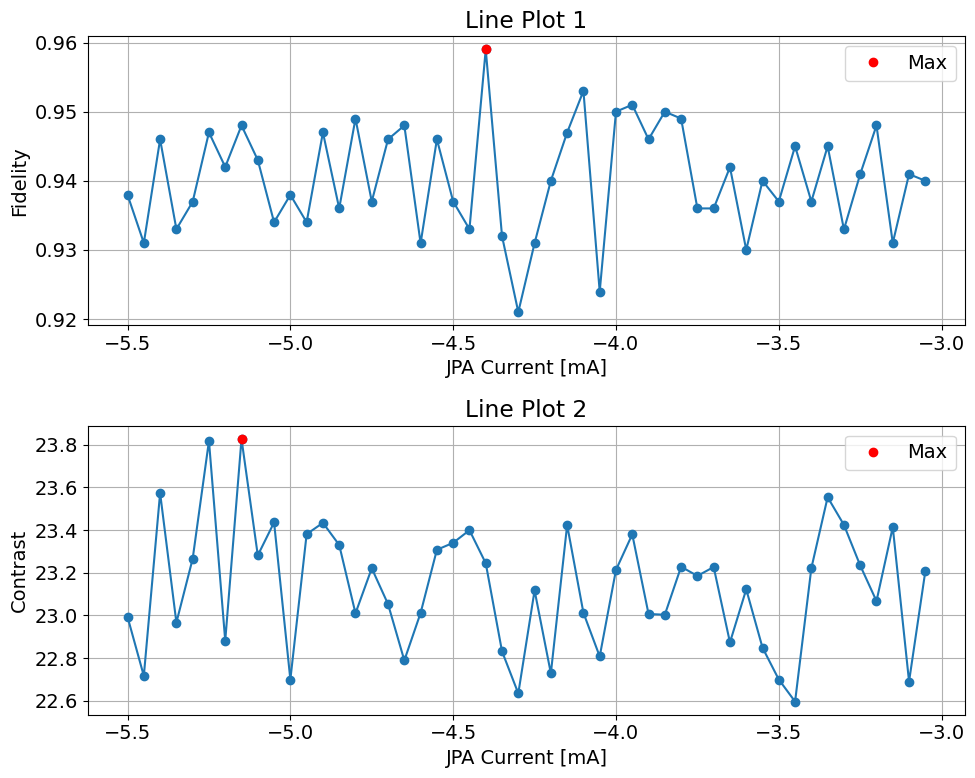

In [ ]:
do_jpa_current_sweep(config_thisrun, expt_path,
                                   config_path, reps=1000,
                                   jpa_current_start=-5.0,
                                   jpa_current_stop=-4.0,
                                   jpa_current_step=0.05,
                                    #  jpa_current_start=0., jpa_current_step=0.2,
                                    #    jpa_current_stop=10., 
                                      #  active_reset=True,
                                         relax_delay=5)

In [ ]:
from slab.instruments import YokogawaGS200
dcflux = YokogawaGS200(address="192.168.137.149")
dcflux.set_output(True)
dcflux.set_mode('current')

jpa_current = -1.875 # mA
jpa_current = 0 # mA
current = jpa_current * 1e-3  # Convert from mA to A
dcflux.set_current(current)

print(1e3 * dcflux.get_current(), 'mA')

#### Sweep both gain and current

In [ ]:
def do_jpa_current_gain_sweep( config_thisrun,
    expt_path,
    config_path,
    jpa_current_start=3.7,
    jpa_current_step=0.005,
    jpa_current_stop = 3.8,
    jpa_gain_start=-15,
    jpa_gain_step=0.5,
    jpa_gain_stop = -11,
    qubits=[0],
    reps=1000,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=2500
):
    """Run the single shot experiment with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import histogram_sweep_class
    experiment_class = histogram_sweep_class
    sweep_experiment_name = 'histogram_jpa_gain_current_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    
    class_for_exp.loaded[sweep_experiment_name] =  {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'jpa_current_start': jpa_current_start,
        'jpa_current_step': jpa_current_step,
        'jpa_current_stop': jpa_current_stop,
        'jpa_gain_start': jpa_gain_start,
        'jpa_gain_step': jpa_gain_step,
        'jpa_gain_stop': jpa_gain_stop,
    }

    print('relax delay set to:', relax_delay)
    class_for_exp.yaml_cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

In [ ]:
sweep_func = do_jpa_current_gain_sweep(config_thisrun, expt_path,
                                        config_path, reps=1000, 
                                        jpa_current_start=-5.5,
                                        jpa_current_step=-0.1,
                                        jpa_current_stop=-4.5,
                                        jpa_gain_start=-15,
                                        jpa_gain_step=0.5,
                                        jpa_gain_stop=-5,
                                        # active_reset=True, relax_delay=5
                                        )

relax delay set to: 2500
HistogramExperiment
Index: 0 Gain. = -15.0


OSError: exception: access violation reading 0x0000000000000040